In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress,LocalCluster
%matplotlib inline

In [3]:
import re
import string

In [2]:
# explore the params
lq=pd.read_csv('Iowa_Liquor_Sales.csv',dtype={'Category': 'float64','Zip Code': 'object'
                                              ,'Item Number': 'object','Vendor Number': 'float64'})
lq.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S31296100034,03/16/2016,3762,Wine and Spirits Gallery,7690 HICKMAN RD,WINDSOR HEIGHTS,50322,NaN,77.0,Polk,...,80457,Ryan's Cream Liqueur,12,1000,7.23,10.85,1,10.85,1.0,0.26
1,INV-20599500022,07/15/2019,4320,Fareway Stores #470 / Perry,NaN,NaN,NaN,NaN,NaN,NaN,...,10008,Scoresby Rare Scotch,6,1750,10.50,15.75,6,94.50,10.5,2.77
2,INV-28403900139,07/01/2020,2643,Hy-Vee Wine and Spirits / Waterloo,2126 Kimball Ave,Waterloo,50701,NaN,7.0,BLACK HAWK,...,15628,Jameson,6,1750,32.48,48.72,2,97.44,3.5,0.92
3,INV-20560900100,07/11/2019,3456,Quick Shop / Clear Lake,NaN,NaN,NaN,NaN,NaN,NaN,...,10009,Scoresby Rare Scotch,12,1000,6.74,10.11,2,20.22,2.0,0.52
4,INV-20784900043,07/23/2019,5151,IDA Liquor,"500, Hwy 175",Ida Grove,51445,NaN,47.0,IDA,...,100107,Captain Morgan OSR Glass w/50ml Apple Smash & ...,6,1850,18.00,27.00,6,162.00,11.1,2.93


### Data Cleaning

In [3]:
lq.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [4]:
lq['Category'].unique().shape

(111,)

In [5]:
lq['Category Name'].unique().shape

(134,)

There's a mismatch in the category name and the category number. Some category names are in lower and some are in upper. Convert All to lower.

In [6]:
lq['Category Name']=lq['Category Name'].str.lower()

In [7]:
lq['Category Name'].unique().shape

(111,)

Now, they're matching.

In [8]:
lq['Category'].isna().sum()

16974

In [9]:
lq['Category Name'].isna().sum()

25040

I'll ignore the missingness for now

In [7]:
lq['Item Number'].unique().shape

(9959,)

In [8]:
lq['Item Description'].unique().shape

(8983,)

Some items may have the same description but different codes. That maybe related to the number of packs. The Item Description will still be cleaned.

In [22]:
# text cleaning function
def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()
    text = re.sub("\+", '', text)
    text = re.sub(',', '', text)
    text = re.sub('\$', '', text)
    text = re.sub('-', ' ', text)
    text = re.sub('[’“”…]', '', text)         
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    return text

In [26]:
# clean the item description column
lq['Item Description']=lq['Item Description'].apply(cleaning)

There were duplicated item names. The number of Item Descriptions decreased from 8983 to 8657.

In [27]:
lq['Item Description'].unique().shape

(8657,)

In [28]:
lq['Item Description'].isna().sum()

0

In [29]:
lq['Item Number'].isna().sum()

0

No missingness with item number and description

Check store numbers and store names

In [30]:
lq['Store Number'].unique().shape

(2534,)

In [31]:
lq['Store Name'].unique().shape

(2689,)

In [32]:
# store names are more than the store number
# clean store names
lq['Store Name']=lq['Store Name'].apply(cleaning)

In [33]:
# the number has decreased but not quite matching
lq['Store Name'].unique().shape

(2649,)

Store number will be more reliable

Check vendor numbers and vendor names

In [34]:
lq['Vendor Number'].unique().shape

(358,)

In [35]:
lq['Vendor Name'].unique().shape

(501,)

In [37]:
# store names are more than the store number
# clean vendor names
lq['Vendor Name']=lq['Vendor Name'].astype(str).apply(cleaning)

In [38]:
# the number has decreased but not quite matching
lq['Vendor Name'].unique().shape

(447,)

In [1]:
# convert date to datetime
#lq['Date']= pd.to_datetime(lq['Date'])

In [39]:
# make seperata databases 
products=lq[['Invoice/Item Number','Category', 'Category Name','Item Number','Item Description']]
db = sqlite3.connect("products.sqlite")
products.to_sql("products",db,if_exists='replace', chunksize=1000,index=False)

C:\Users\Ibrahim\anaconda3\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [40]:
product_prices=lq[['Invoice/Item Number', 'Date','State Bottle Cost','State Bottle Retail']]
db = sqlite3.connect("product_prices.sqlite")
product_prices.to_sql("product_prices",db,if_exists='replace', chunksize=1000,index=False)

In [41]:
stores=lq[['Invoice/Item Number','Store Number', 'Store Name','Store Location']]
db = sqlite3.connect("stores.sqlite")
stores.to_sql("stores",db,if_exists='replace', chunksize=1000,index=False)

In [42]:
vendors=lq[['Invoice/Item Number', 'Vendor Number', 'Vendor Name']]
db = sqlite3.connect("vendors.sqlite")
vendors.to_sql("vendors",db,if_exists='replace', chunksize=1000,index=False)

In [43]:
transactions=lq[['Invoice/Item Number', 'Date','Vendor Number','Store Number','Item Number','Bottles Sold','Sale (Dollars)']]
db = sqlite3.connect("transactions.sqlite")
transactions.to_sql("transactions",db,if_exists='replace', chunksize=1000,index=False)

In [28]:
lq.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object')

In [44]:
the_rest=lq[['Invoice/Item Number','Address','City', 'Zip Code','County Number', 'County',
            'Pack', 'Bottle Volume (ml)','State Bottle Cost',
             'Volume Sold (Liters)', 'Volume Sold (Gallons)']]
db = sqlite3.connect("the_rest.sqlite")
the_rest.to_sql("the_rest",db,if_exists='replace', chunksize=1000,index=False)

### Load the dataframes from the databases

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress,LocalCluster
import math
%matplotlib inline

In [4]:
import seaborn as sns

In [5]:
from sklearn.cluster import KMeans

In [6]:
from sklearn import preprocessing

#### What are the most popular categories?

In [241]:
# get all category names and numbers
conn=sqlite3.connect("products.sqlite")
Cats=pd.read_sql('SELECT "Category Name" FROM products', conn)

In [19]:
# coarse graining the categories
Cats['Category Name'].unique()

array(['cream liqueurs', 'scotch whiskies', 'irish whiskies',
       'temporary & specialty packages', '100% agave tequila',
       'canadian whiskies', 'mixto tequila', 'cocktails /rtd',
       'american schnapps', 'coffee liqueurs', 'spiced rum',
       'straight bourbon whiskies', 'gold rum', 'american vodkas',
       'blended whiskies', 'vodka 80 proof', 'white rum',
       'american brandies', 'imported vodkas', 'flavored rum',
       'whiskey liqueur', 'imported brandies', 'triple sec',
       'bottled in bond bourbon', 'straight rye whiskies',
       'single barrel bourbon whiskies', 'american dry gins',
       'tennessee whiskies', 'imported dry gins',
       'american cordials & liqueur', 'corn whiskies', 'imported vodka',
       'vodka flavored', 'mezcal', 'single malt scotch',
       'imported schnapps', 'flavored gin', 'imported flavored vodka',
       'tequila', 'american sloe gins', 'american flavored vodka',
       'imported vodka - misc', 'neutral grain spirits',
      

In [242]:
# coarse graining the categories
Liqueur=['cream liqueurs','coffee liqueurs','whiskey liqueur','american cordials & liqueur',
        'american cordials & liqueurs','misc. american cordials & liqueurs',
        'american schnapps','peppermint schnapps','peach schnapps','watermelon schnapps','strawberry schnapps',
           'raspberry schnapps', 'cinnamon schnapps','apple schnapps','tropical fruit schnapps','grape schnapps',
            'butterscotch schnapps','miscellaneous schnapps', 'spearmint schnapps', 'root beer schnapps',
        'triple sec','american amaretto','anisette','dark creme de cacao', 'green creme de menthe',
        'creme de almond','white creme de cacao','white creme de menthe']
Tequila=['100% agave tequila','mixto tequila','tequila', '100% agave tequila','mezcal']
USWhiskies=['straight bourbon whiskies','blended whiskies','bottled in bond bourbon',
           'straight rye whiskies','single barrel bourbon whiskies','tennessee whiskies',
           'corn whiskies', 'iowa distillery whiskies','rock & rye']
USRum=['spiced rum', 'gold rum', 'white rum', 'flavored rum','puerto rico & virgin islands rum','aged dark rum']
USGin=['american dry gins','flavored gin', 'american sloe gins']
USVodka=['american vodkas', 'vodka 80 proof','vodka flavored','american flavored vodka',
        'american vodka', '100 proof vodka', 'other proof vodka', 'low proof vodka']
USBrandy=['american brandies','miscellaneous  brandies','blackberry brandies','american grape brandies',
         'apricot brandies','cherry brandies','peach brandies']

ImportedRum=['jamaica rum','barbados rum']
ImportedGin=['imported dry gins','imported gins']
ImportedBrandy=['imported brandies','imported grape brandies']
ImportWhiskies=['scotch whiskies', 'irish whiskies','canadian whiskies', 'single malt scotch','japanese whisky']
ImportedVodka=['imported vodkas','imported vodka', 'imported flavored vodka',
               'imported vodka - misc','imported vodka - cherry']
ImportedLiqueur=['imported cordials & liqueurs','imported cordials & liqueur', 'misc. imported cordials & liqueurs',
                'amaretto - imported','imported schnapps', 'schnapps - imported','imported amaretto']
Cocktails=['cocktails /rtd','cocktails / rtd','american cocktails']

Specialty=['temporary & specialty packages','imported distilled spirit specialty','american distilled spirit specialty',
          'temporary  & specialty packages','decanters & specialty packages','distilled spirits specialty',
          'imported distilled spirits specialty', 'temporary &  specialty packages',
         'delisted / special order items','american distilled spirits specialty','special order items','holiday vap']

misc=['neutral grain spirits', 'None','neutral grain spirits flavored', 'iowa distilleries',
         'american alcohol',  'delisted items','high proof beer - american']

In [243]:
# Get the volume sold
conn=sqlite3.connect("the_rest.sqlite")
VolSales=pd.read_sql('SELECT "Volume Sold (Liters)" FROM the_rest', conn)

In [244]:
# Get the sales
conn=sqlite3.connect("transactions.sqlite")
Sales=pd.read_sql('SELECT "Sale (Dollars)" FROM transactions', conn)

In [254]:
%%time
limit=Cats.shape[0]
step=1000
CoarseCats=[]
#i=0
# accessing a 20 mil dataset every iteration consumes a lot of time. I'm breaking the iterations into chunks
chunck_start= range(0,limit,step)
for start in chunck_start:
    if start == math.floor(limit/step)*step:
        end = limit+1
    else:
        end=start+step
    CatsNames=Cats['Category Name'][start:end]
    
    for name in CatsNames:
        if name in Liqueur:
            CoarseCats.append("Liqueur")
        elif name in Tequila:
            CoarseCats.append("Tequila")
        elif name in USWhiskies:
            CoarseCats.append("USWhiskies")
        elif name in USRum:
            CoarseCats.append('USRum')
        elif name in USGin:
            CoarseCats.append('USGin')
        elif name in USVodka:
            CoarseCats.append('USVodka')
        elif name in USBrandy:
            CoarseCats.append('USBrandy')
        elif name in ImportedRum:
            CoarseCats.append('ImportedRum')
        elif name in ImportedGin:
            CoarseCats.append('ImportedGin')
        elif name in ImportedBrandy:
            CoarseCats.append('ImportedBrandy')
        elif name in ImportWhiskies:
            CoarseCats.append('ImportWhiskies')
        elif name in ImportedVodka:
            CoarseCats.append('ImportedVodka')
        elif name in ImportedLiqueur:
            CoarseCats.append('ImportedLiqueur')
        elif name in Cocktails:
            CoarseCats.append('Cocktails')
        elif name in Specialty:
            CoarseCats.append('Specialty')
        elif name in misc:
            CoarseCats.append("Misc.")
        else:
            CoarseCats.append("None")
        #i=i+1

Wall time: 30.6 s


In [255]:
len(CoarseCats)

20546005

In [8]:
len(CoarseCats)

20546005

In [256]:
Cats['Coarse Category']=CoarseCats
Cats

,Category Name,Coarse Category
0,cream liqueurs,Liqueur
1,scotch whiskies,ImportWhiskies
2,irish whiskies,ImportWhiskies
3,scotch whiskies,ImportWhiskies
4,temporary & specialty packages,Specialty
...,...,...
20546000,american brandies,USBrandy
20546001,imported cordials & liqueurs,ImportedLiqueur
20546002,american vodkas,USVodka
20546003,american dry gins,USGin


In [257]:
Cats.groupby('Coarse Category').get_group('None')['Category Name'].unique()

array([None, 'flavored gins'], dtype=object)

In [258]:
# save the database
db = sqlite3.connect("coarse_categories.sqlite")
Cats.to_sql("coarse_categories",db,if_exists='replace', chunksize=1000)

C:\Users\Ibrahim\anaconda3\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [259]:
# find the most sold categories
CoarseCatsVol=pd.concat([Cats['Coarse Category'],VolSales['Volume Sold (Liters)'],Sales],axis=1)
CoarseCatsVol

,Coarse Category,Volume Sold (Liters),Sale (Dollars)
0,Liqueur,1.00,10.85
1,ImportWhiskies,10.50,94.50
2,ImportWhiskies,3.50,97.44
3,ImportWhiskies,2.00,20.22
4,Specialty,11.10,162.00
...,...,...,...
20546000,USBrandy,0.25,53.40
20546001,ImportedLiqueur,0.05,18.66
20546002,USVodka,9.60,81.60
20546003,USGin,5.25,32.01


In [260]:
# group by the category and sum the sold volumes
CoarseCatsGroups=CoarseCatsVol.groupby('Coarse Category').sum().sort_values(by=['Volume Sold (Liters)'],ascending=False)
CoarseCatsGroups

,Volume Sold (Liters),Sale (Dollars)
Coarse Category,,
USVodka,4.730374e+07,4.556778e+08
ImportWhiskies,2.927803e+07,4.675065e+08
USRum,2.409626e+07,3.340858e+08
USWhiskies,2.129540e+07,4.055512e+08
Liqueur,2.024295e+07,3.077003e+08
ImportedVodka,1.020093e+07,2.075968e+08
Tequila,7.370088e+06,1.634522e+08
Cocktails,6.965300e+06,4.949373e+07
ImportedLiqueur,5.331799e+06,1.233748e+08


Text(0.5, 1.0, 'Volume Sold in (Million Litre) since 2012')

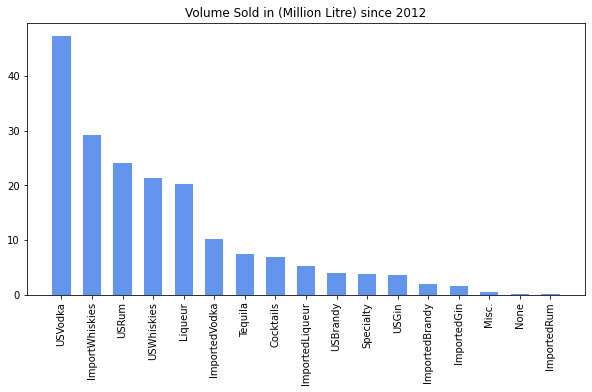

In [261]:
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(CoarseCatsGroups.index, CoarseCatsGroups['Volume Sold (Liters)']/1e6,width=0.6, color='cornflowerblue')
plt.xticks(rotation='vertical')
plt.title('Volume Sold in (Million Litre) since 2012')

In [262]:
CoarseCatsGroups.sort_values(by=['Sale (Dollars)'],inplace=True,ascending=False)
CoarseCatsGroups

,Volume Sold (Liters),Sale (Dollars)
Coarse Category,,
ImportWhiskies,2.927803e+07,4.675065e+08
USVodka,4.730374e+07,4.556778e+08
USWhiskies,2.129540e+07,4.055512e+08
USRum,2.409626e+07,3.340858e+08
Liqueur,2.024295e+07,3.077003e+08
ImportedVodka,1.020093e+07,2.075968e+08
Tequila,7.370088e+06,1.634522e+08
ImportedLiqueur,5.331799e+06,1.233748e+08
ImportedBrandy,1.901781e+06,7.931577e+07


Text(0.5, 1.0, 'Total Sales (Million Dollars) since 2012')

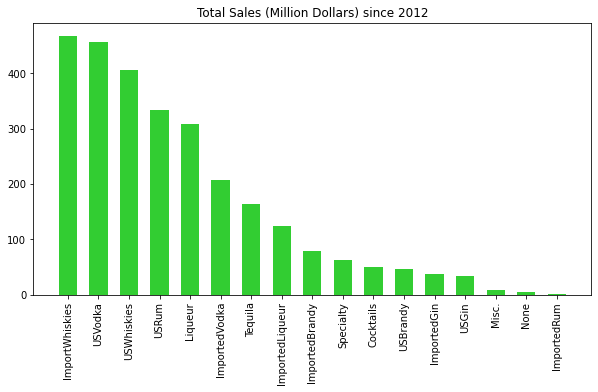

In [263]:
plt.bar(CoarseCatsGroups.index, CoarseCatsGroups['Sale (Dollars)']/1e6,width=0.6, color='limegreen')
plt.xticks(rotation='vertical')
plt.title('Total Sales (Million Dollars) since 2012')

Text(0, 0.5, 'Sales (Million Dollars)')

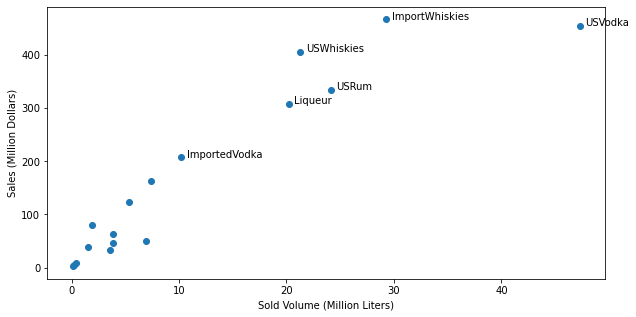

In [264]:
plt.scatter(CoarseCatsGroups['Volume Sold (Liters)']/1e6,CoarseCatsGroups['Sale (Dollars)']/1e6)
for i, txt in enumerate(CoarseCatsGroups.index):
    if i <= 5:
        plt.annotate(txt, (CoarseCatsGroups['Volume Sold (Liters)'][i]/1e6+0.5, CoarseCatsGroups['Sale (Dollars)'][i]/1e6))
plt.xlabel('Sold Volume (Million Liters)')
plt.ylabel('Sales (Million Dollars)')

#### Sale/Volume ratio

In [7]:
conn=sqlite3.connect("coarse_categories.sqlite")
CoarseCats=pd.read_sql('SELECT "Coarse Category" FROM coarse_categories', conn)

In [8]:
conn=sqlite3.connect("the_rest.sqlite")
VolSales=pd.read_sql('SELECT "Volume Sold (Liters)" FROM the_rest', conn)

In [9]:
conn=sqlite3.connect("transactions.sqlite")
Sales=pd.read_sql('SELECT "Sale (Dollars)" FROM transactions', conn)

In [48]:
CoarseCatsVol=pd.concat([CoarseCats,VolSales,Sales],axis=1)
CoarseCatsVol

,Coarse Category,Volume Sold (Liters),Sale (Dollars)
0,Liqueur,1.00,10.85
1,ImportWhiskies,10.50,94.50
2,ImportWhiskies,3.50,97.44
3,ImportWhiskies,2.00,20.22
4,Specialty,11.10,162.00
...,...,...,...
20546000,USBrandy,0.25,53.40
20546001,ImportedLiqueur,0.05,18.66
20546002,USVodka,9.60,81.60
20546003,USGin,5.25,32.01


In [7]:
CoarseCatsGroups=CoarseCatsVol.groupby('Coarse Category').sum()
CoarseCatsGroups

,Volume Sold (Liters),Sale (Dollars)
Coarse Category,,
Cocktails,6.965300e+06,4.949373e+07
ImportWhiskies,2.927803e+07,4.675065e+08
ImportedBrandy,1.901781e+06,7.931577e+07
ImportedGin,1.558384e+06,3.789794e+07
ImportedLiqueur,5.331799e+06,1.233748e+08
ImportedRum,1.100081e+05,2.107456e+06
ImportedVodka,1.020093e+07,2.075968e+08
Liqueur,2.024295e+07,3.077003e+08
Misc.,4.324357e+05,8.382732e+06


In [147]:
CoarseCatsGroups['Sale/Volume Ratio ($/Liter)']=CoarseCatsGroups['Sale (Dollars)']/CoarseCatsGroups['Volume Sold (Liters)']
CoarseCatsGroups.sort_values(by=['Sale/Volume Ratio ($/Liter)'],inplace=True)

In [148]:
CoarseCatsGroups

,Volume Sold (Liters),Sale (Dollars),Sale/Volume Ratio ($/Liter)
Coarse Category,,,
Cocktails,6.965300e+06,4.949373e+07,7.105758
USGin,3.556565e+06,3.323001e+07,9.343287
USVodka,4.730374e+07,4.556778e+08,9.633019
USBrandy,3.893248e+06,4.650161e+07,11.944167
USRum,2.409626e+07,3.340858e+08,13.864633
Liqueur,2.024295e+07,3.077003e+08,15.200369
ImportWhiskies,2.927803e+07,4.675065e+08,15.967826
Specialty,3.864387e+06,6.369971e+07,16.483781
USWhiskies,2.129540e+07,4.055512e+08,19.044077


Text(0.5, 1.0, 'Sale/Volume Ratio ($/Liter) since 2012')

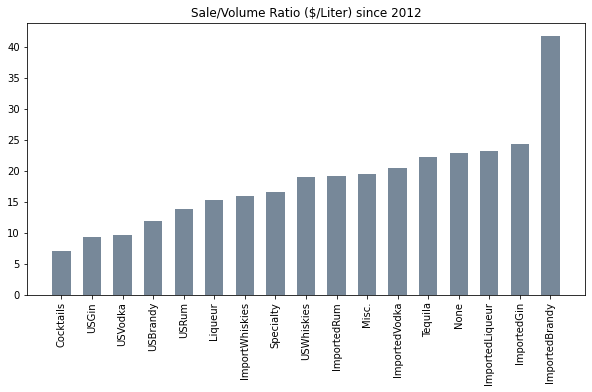

In [149]:
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(CoarseCatsGroups.index, CoarseCatsGroups['Sale/Volume Ratio ($/Liter)'],width=0.6, color='lightslategrey')
plt.xticks(rotation='vertical')
plt.title('Sale/Volume Ratio ($/Liter) since 2012')

#### Product Life Cycles

In [11]:
conn=sqlite3.connect("products.sqlite")
items=pd.read_sql('SELECT "Item Description" FROM products', conn)

In [6]:
conn=sqlite3.connect("transactions.sqlite")
dates=pd.read_sql('SELECT "Date" FROM transactions', conn)

In [12]:
ItemTrans=pd.concat([dates,CoarseCats,items, Sales["Sale (Dollars)"],VolSales['Volume Sold (Liters)']],axis=1)
ItemTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters)
0,03/16/2016,Liqueur,ryans cream liqueur,10.85,1.0
1,07/15/2019,ImportWhiskies,scoresby rare scotch,94.50,10.5
2,07/01/2020,ImportWhiskies,jameson,97.44,3.5
3,07/11/2019,ImportWhiskies,scoresby rare scotch,20.22,2.0
4,07/23/2019,Specialty,captain morgan osr glass w50ml apple smash 50...,162.00,11.1


In [13]:
ItemTrans['Date']= pd.to_datetime(ItemTrans['Date'])

In [14]:
ItemTrans['Date'].isna().sum()

0

In [15]:
g=ItemTrans.groupby(pd.Grouper(key='Date', freq='Y'))

In [16]:
# Restrict the analysis to the items that only were being sold from 2012 until the end of 2020
from functools import reduce
common_products=reduce(np.intersect1d, (
                        g.get_group('2020-12-31')['Item Description'].unique(),
                        g.get_group('2019-12-31')['Item Description'].unique(),
                        g.get_group('2018-12-31')['Item Description'].unique(),
                        g.get_group('2017-12-31')['Item Description'].unique(),
                        g.get_group('2016-12-31')['Item Description'].unique(),
                        g.get_group('2015-12-31')['Item Description'].unique(),
                        g.get_group('2014-12-31')['Item Description'].unique(),
                        g.get_group('2013-12-31')['Item Description'].unique(),
                        g.get_group('2012-12-31')['Item Description'].unique()
                       ))

In [17]:
common_products.shape

(544,)

In [18]:
ItemTransC=ItemTrans[ItemTrans['Item Description'].isin(common_products)]

In [19]:
ItemTransC.shape

(10713127, 5)

In [20]:
ItemTransC.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters)
0,2016-03-16,Liqueur,ryans cream liqueur,10.85,1.0
1,2019-07-15,ImportWhiskies,scoresby rare scotch,94.50,10.5
2,2020-07-01,ImportWhiskies,jameson,97.44,3.5
3,2019-07-11,ImportWhiskies,scoresby rare scotch,20.22,2.0
9,2019-07-09,ImportWhiskies,ushers green stripe,90.00,10.5


In [21]:
ItemTransg=ItemTransC.groupby(['Item Description']).sum()
ItemTransg

,Sale (Dollars),Volume Sold (Liters)
Item Description,,
1800 coconut,211865.89,7099.50
1800 ultimate margarita,925326.45,110243.00
360 vodka,234425.50,16284.74
8 seconds canadian whiskey,16011.60,495.00
99 apples,209965.36,13041.00
...,...,...
woodford reserve,3371261.11,79689.91
woodford reserve double oaked,1085117.28,18018.75
x rated fusion liqueur,353901.32,12412.00


In [22]:
# top ten popular products
topbrands=ItemTransg.sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:10]
topbrands

,Sale (Dollars),Volume Sold (Liters)
Item Description,,
black velvet,1.117333e+08,1.203045e+07
hawkeye vodka,5.091352e+07,8.031291e+06
titos handmade vodka,7.752715e+07,4.338872e+06
five oclock vodka,2.715813e+07,4.199478e+06
fireball cinnamon whiskey,6.157019e+07,3.822735e+06
barton vodka,2.087171e+07,3.482558e+06
phillips vodka,1.648803e+07,2.538732e+06
admiral nelson spiced rum,2.322884e+07,2.226069e+06
jim beam,3.502475e+07,1.845090e+06


In [23]:
# Associated group with each brand
lc=[]
for itemname in topbrands.index:
    lc.append(ItemTransC[ItemTransC['Item Description']==itemname]['Coarse Category'].iloc[0])

In [24]:
topbrands['Coarse Category']=lc
topbrands

,Sale (Dollars),Volume Sold (Liters),Coarse Category
Item Description,,,
black velvet,1.117333e+08,1.203045e+07,ImportWhiskies
hawkeye vodka,5.091352e+07,8.031291e+06,USVodka
titos handmade vodka,7.752715e+07,4.338872e+06,USVodka
five oclock vodka,2.715813e+07,4.199478e+06,USVodka
fireball cinnamon whiskey,6.157019e+07,3.822735e+06,Liqueur
barton vodka,2.087171e+07,3.482558e+06,USVodka
phillips vodka,1.648803e+07,2.538732e+06,USVodka
admiral nelson spiced rum,2.322884e+07,2.226069e+06,USRum
jim beam,3.502475e+07,1.845090e+06,USWhiskies


In [25]:
TopItemsVolSales=ItemTransC[ItemTransC['Item Description'].isin(topbrands.index)]
TopItemsVolSales

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters)
12,2020-11-02,ImportWhiskies,black velvet,119.40,12.00
32,2020-02-03,USRum,captain morgan original spiced,180.00,9.00
33,2020-07-01,USWhiskies,jim beam,189.00,10.50
40,2020-02-03,USVodka,titos handmade vodka,171.00,10.50
74,2020-02-04,USVodka,hawkeye vodka,64.56,10.50
...,...,...,...,...,...
20545969,2021-01-29,ImportWhiskies,black velvet,36.88,3.00
20545971,2021-01-29,ImportWhiskies,black velvet,110.64,9.00
20545987,2021-01-29,USVodka,hawkeye vodka,66.96,9.00
20545989,2021-01-29,Liqueur,fireball cinnamon whiskey,13.50,0.75


In [26]:
# Aggrigated sales to figure out the cycle patterns for the top brands
AggrMonthlySales=TopItemsVolSales.groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()
AggrMonthlySales

,Date,Sale (Dollars),Volume Sold (Liters)
0,2012-01-31,2088627.64,246579.61
1,2012-02-29,2847973.29,332553.41
2,2012-03-31,2267686.54,269287.38
3,2012-04-30,2343102.13,273669.50
4,2012-05-31,3396208.43,402861.88
...,...,...,...
104,2020-09-30,7374828.23,572748.88
105,2020-10-31,6905709.49,535933.95
106,2020-11-30,5417145.92,437257.44
107,2020-12-31,6863526.19,569439.99


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Sale-Volume of Top 10 Brands')

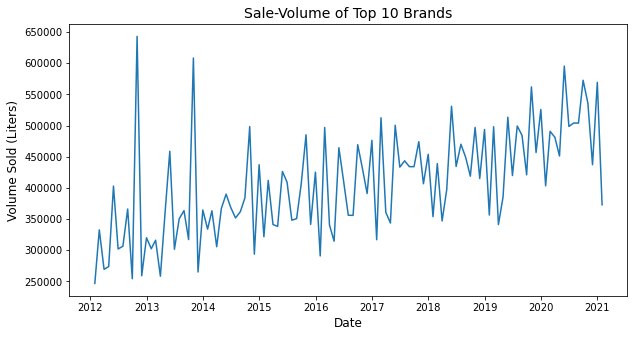

In [27]:
# Analyze the spikes
plt.rcParams['figure.figsize'] = (10,5)
#ItemVolSales=MonthlySales[MonthlySales['Item Description']==topbrands.index[0]]
fig=sns.lineplot(AggrMonthlySales.Date,AggrMonthlySales['Volume Sold (Liters)'])
#plt.xlim('2012-01-01','2015-01-01')
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('Sale-Volume of Top 10 Brands',fontsize=14)

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


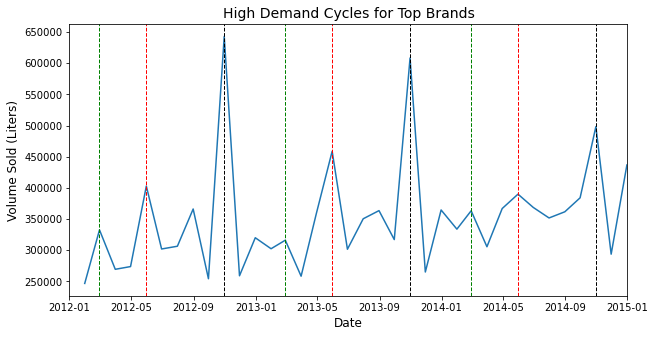

In [28]:
plt.rcParams['figure.figsize'] = (10,5)
#ItemVolSales=MonthlySales[MonthlySales['Item Description']==topbrands.index[0]]
fig=sns.lineplot(AggrMonthlySales.Date,AggrMonthlySales['Volume Sold (Liters)'])
plt.xlim('2012-01-01','2015-01-01')
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('High Demand Cycles for Top Brands',fontsize=14)
plt.axvline('2012-10-31',color='black', linestyle='dashed', linewidth=1)
plt.axvline('2013-10-31',color='black', linestyle='dashed', linewidth=1)
plt.axvline('2014-10-31',color='black', linestyle='dashed', linewidth=1)


plt.axvline('2012-02-29',color='green', linestyle='dashed', linewidth=1)
plt.axvline('2013-02-28',color='green', linestyle='dashed', linewidth=1)
plt.axvline('2014-02-28',color='green', linestyle='dashed', linewidth=1)

plt.axvline('2012-05-31',color='red', linestyle='dashed', linewidth=1)
plt.axvline('2013-05-31',color='red', linestyle='dashed', linewidth=1)
plt.axvline('2014-05-31',color='red', linestyle='dashed', linewidth=1)

In [29]:
MonthlySales=TopItemsVolSales.groupby(['Item Description',pd.Grouper(key='Date', freq='M')]).sum().reset_index()

In [30]:
MonthlySales

,Item Description,Date,Sale (Dollars),Volume Sold (Liters)
0,admiral nelson spiced rum,2012-01-31,101257.57,9450.02
1,admiral nelson spiced rum,2012-02-29,202779.36,19603.92
2,admiral nelson spiced rum,2012-03-31,219107.01,21189.82
3,admiral nelson spiced rum,2012-04-30,155880.78,14915.24
4,admiral nelson spiced rum,2012-05-31,236048.55,22796.18
...,...,...,...,...
1085,titos handmade vodka,2020-09-30,2786684.62,151743.98
1086,titos handmade vodka,2020-10-31,2207233.98,121761.99
1087,titos handmade vodka,2020-11-30,1752997.07,99657.90
1088,titos handmade vodka,2020-12-31,1601477.48,87319.27


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim

Text(0.5, 1.0, 'PLC of Top 10 Brands')

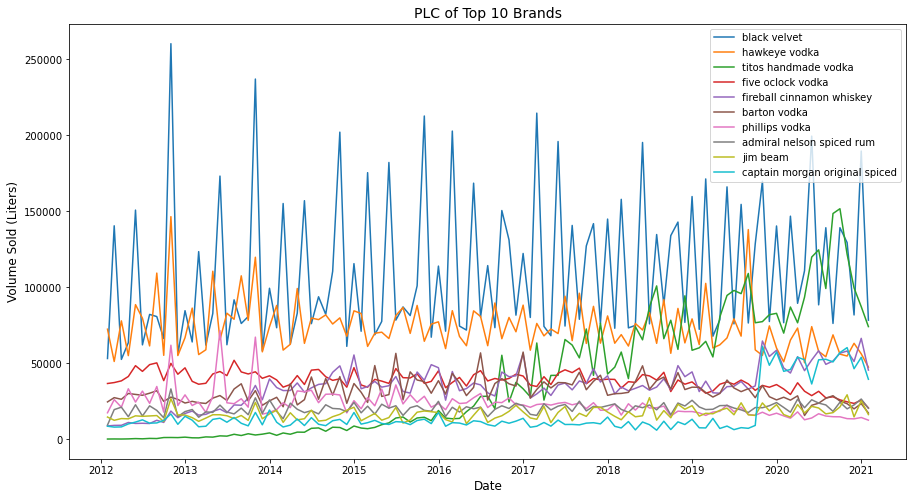

In [31]:
plt.rcParams['figure.figsize'] = (15,8)
for i in range(0,10,1):
    ItemVolSales=MonthlySales[MonthlySales['Item Description']==topbrands.index[i]]
    #sns.lineplot(ItemVolSales.Date.dt.strftime('%Y-%m-%d'),ItemVolSales['Volume Sold (Liters)'],
     #            label=topbrands.index[i]).set_xticklabels(labels= ItemVolSales.Date.dt.strftime('%Y-%m-%d'),
      #                                                     rotation=90, ha='right')
    fig=sns.lineplot(ItemVolSales.Date,ItemVolSales['Volume Sold (Liters)'],label=topbrands.index[i])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('PLC of Top 10 Brands',fontsize=14)

### RFM for Tito's Vodka

Tito's has been trending up on the sales volume. We are going to study the customers-brand relationship and the customer segmentation for Tito's 

In [38]:
TitosSales=MonthlySales[MonthlySales['Item Description']=='titos handmade vodka']

In [39]:
#TitosSales['EMA Sales']=TitosSales['Sale (Dollars)'].ewm(span=5,adjust=False).mean()

In [40]:
TitosSales.head()

,Item Description,Date,Sale (Dollars),Volume Sold (Liters)
981,titos handmade vodka,2012-01-31,3860.03,243.25
982,titos handmade vodka,2012-02-29,4609.82,290.50
983,titos handmade vodka,2012-03-31,3971.11,250.25
984,titos handmade vodka,2012-04-30,5331.84,336.00
985,titos handmade vodka,2012-05-31,8525.39,537.25


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Titos Vodka Monthly Sales (Dollars)')

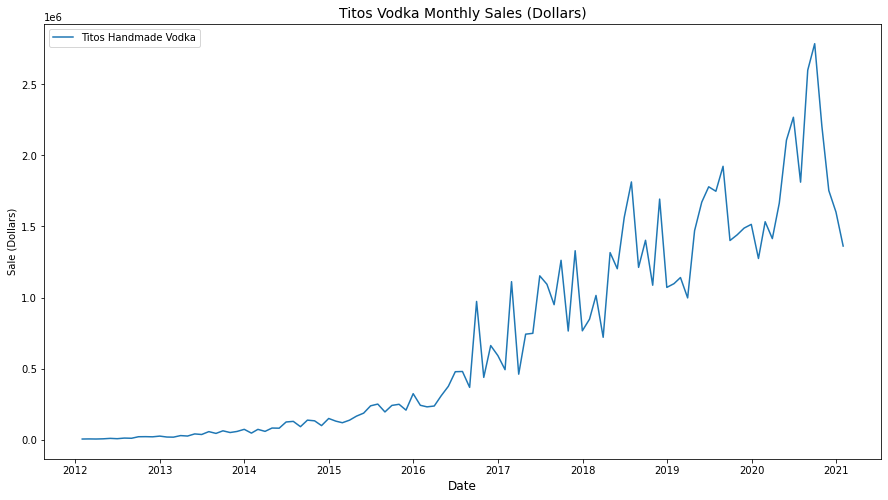

In [41]:
# Titos Sales (Dollars)
fig=sns.lineplot(TitosSales.Date,TitosSales['Sale (Dollars)'],label='Titos Handmade Vodka')
fig.set_xlabel('Date',fontsize=12)
fig.set_title('Titos Vodka Monthly Sales (Dollars)',fontsize=14)

#### Recency
How many inactive days for each store?

In [42]:
# Pull store numbers and names
conn=sqlite3.connect("stores.sqlite")
stores=pd.read_sql('SELECT "Invoice/Item Number","Store Number", "Store Name" FROM stores', conn)
stores.head()

,Invoice/Item Number,Store Number,Store Name
0,S31296100034,3762,wine and spirits gallery
1,INV-20599500022,4320,fareway stores 470 perry
2,INV-28403900139,2643,hy vee wine and spirits waterloo
3,INV-20560900100,3456,quick shop clear lake
4,INV-20784900043,5151,ida liquor


In [43]:
ItemTrans=pd.concat([ItemTrans,stores],axis=1)
ItemTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
0,2016-03-16,Liqueur,ryans cream liqueur,10.85,1.0,S31296100034,3762,wine and spirits gallery
1,2019-07-15,ImportWhiskies,scoresby rare scotch,94.50,10.5,INV-20599500022,4320,fareway stores 470 perry
2,2020-07-01,ImportWhiskies,jameson,97.44,3.5,INV-28403900139,2643,hy vee wine and spirits waterloo
3,2019-07-11,ImportWhiskies,scoresby rare scotch,20.22,2.0,INV-20560900100,3456,quick shop clear lake
4,2019-07-23,Specialty,captain morgan osr glass w50ml apple smash 50...,162.00,11.1,INV-20784900043,5151,ida liquor


In [44]:
# get only the transactions for titos
TitosTrans=ItemTrans[ItemTrans['Item Description']=='titos handmade vodka']
TitosTrans

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
40,2020-02-03,USVodka,titos handmade vodka,171.00,10.50,INV-24978400002,4116,lake view foods
138,2020-11-03,USVodka,titos handmade vodka,228.12,12.00,INV-31637100031,4019,wal mart 1506 manchester
856,2019-07-18,USVodka,titos handmade vodka,16.26,0.75,INV-20706400109,3456,quick shop clear lake
859,2019-07-09,USVodka,titos handmade vodka,173.52,9.00,INV-20507500004,3742,wal mart 1625 lemars
863,2019-07-22,USVodka,titos handmade vodka,1735.20,90.00,INV-20748500037,2528,hy vee food store 3 des moines
...,...,...,...,...,...,...,...,...
20545780,2021-01-29,USVodka,titos handmade vodka,40.65,1.87,INV-33881500041,4448,kum go 572 urbandale
20545814,2021-01-29,USVodka,titos handmade vodka,28.50,1.75,INV-33881500002,4448,kum go 572 urbandale
20545815,2021-01-29,USVodka,titos handmade vodka,180.00,9.00,INV-33884700011,2507,hy vee food store 1 burlington
20545835,2021-01-29,USVodka,titos handmade vodka,684.36,36.00,INV-33910800112,2644,hy vee fort dodge wine and spirits


In [13]:
# in case Date wasn't transferred to datetime in ItemTrans after collecting it from the database
TitosTrans['Date']= pd.to_datetime(TitosTrans['Date'])

<ipython-input-13-005abcc4443e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TitosTrans['Date']= pd.to_datetime(TitosTrans['Date'])


In [45]:
TitosTrans['Store Number'].unique().shape

(2079,)

In [46]:
# will use the number because store name may be written differently
TitosTrans['Store Name'].unique().shape

(2149,)

In [47]:
# get the all the unique store numbers
storeRFM=pd.DataFrame(TitosTrans['Store Number'].unique())
storeRFM.columns=['Store Number']

In [48]:
storeRFM.head()

,Store Number
0,4116
1,4019
2,3456
3,3742
4,2528


In [49]:
#get the max purchase date for each customer and create a dataframe with it
titos_max_purchase = TitosTrans.groupby('Store Number').Date.max().reset_index()
titos_max_purchase.columns = ['Store Number','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
titos_max_purchase['Recency'] = (titos_max_purchase['MaxPurchaseDate'].max() - titos_max_purchase['MaxPurchaseDate']).dt.days

In [50]:
titos_max_purchase

,Store Number,MaxPurchaseDate,Recency
0,2106,2021-01-28,1
1,2113,2020-01-27,368
2,2130,2021-01-28,1
3,2152,2014-03-03,2524
4,2178,2021-01-08,21
...,...,...,...
2074,6099,2021-01-27,2
2075,6102,2021-01-26,3
2076,6103,2021-01-27,2
2077,6108,2021-01-29,0


In [51]:
#merge this dataframe to our new user dataframe
storeRFM = pd.merge(storeRFM,titos_max_purchase[['Store Number','Recency']],on=['Store Number'])
storeRFM.head()

,Store Number,Recency
0,4116,11
1,4019,3
2,3456,1
3,3742,3
4,2528,1


Text(0.5, 1.0, 'Recency')

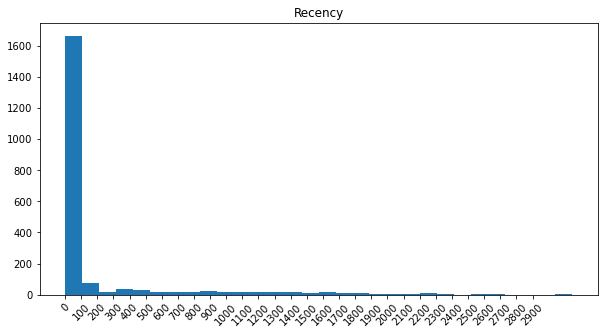

In [52]:
# histogram of recency
plt.rcParams['figure.figsize'] = (10,5)
plt.hist(storeRFM['Recency'],bins=30)
plt.xticks(range(0,3000,100),rotation=45)
plt.title('Recency')

Most stores (75%) have as low recency as 56 days

In [53]:
storeRFM.Recency.describe()

count    2079.000000
mean      202.968254
std       487.976043
min         0.000000
25%         4.000000
50%        16.000000
75%        56.000000
max      3147.000000
Name: Recency, dtype: float64

Apply clustering based on the Recency

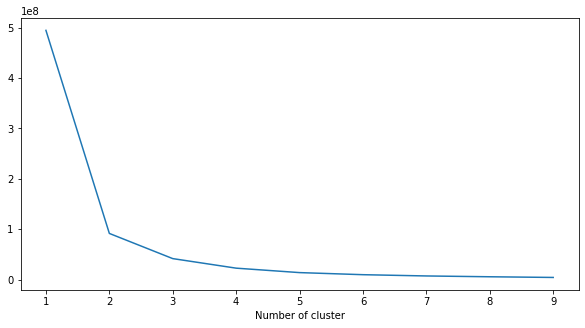

In [85]:
# find the most appropriate number of clusters from the elbow curve
cluster_range=range(1,10)
sse=[]
recency = storeRFM[['Recency']]
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    #recency["clusters"] = kmeans.labels_
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(cluster_range, sse)
plt.xlabel("Number of cluster")
plt.show()

Three clusters seem to be the most optimum choice

In [86]:
# build three cluster and assign
kmeans = KMeans(n_clusters=3)
kmeans.fit(storeRFM[['Recency']])
storeRFM['Recency Cluster'] = kmeans.predict(storeRFM[['Recency']])
storeRFM.head()

,Store Number,Recency,Recency Cluster
0,4116,11,0
1,4019,3,0
2,3456,1,0
3,3742,3,0
4,2528,1,0


In [94]:
# get stats for each cluster
storeRFM.groupby('Recency Cluster')['Recency'].agg(['count','mean','std']).reset_index()

,Recency Cluster,count,mean,std
0,0,1814,37.630650,78.539820
1,1,97,1981.824742,427.963175
2,2,168,961.142857,278.455778


A function to reorder cluster (borrowed from https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444)

In [96]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [99]:
storeRFM=order_cluster('Recency Cluster', 'Recency',storeRFM,False)

Categories:
<br>
0: Low Recency or High inactivity
<br>
1: Medium Recency or Medium inactivity
<br>
2: High Recency or Low Inactivity 

In [100]:
storeRFM.groupby('Recency Cluster')['Recency'].agg(['count','mean','std']).reset_index()

,Recency Cluster,count,mean,std
0,0,97,1981.824742,427.963175
1,1,168,961.142857,278.455778
2,2,1814,37.630650,78.539820


#### Frequency
How many order did each store make?

In [54]:
storeF=TitosTrans.groupby('Store Number')['Invoice/Item Number'].count().reset_index().rename(index=str,columns={'Invoice/Item Number':'Frequency'})
storeF.head()

,Store Number,Frequency
0,2106,379
1,2113,185
2,2130,273
3,2152,1
4,2178,223


Text(0.5, 1.0, 'Frequency')

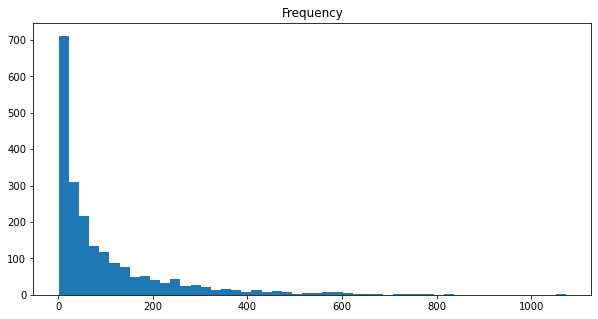

In [55]:
plt.hist(storeF['Frequency'],bins=50)
plt.title('Frequency')

In [56]:
storeF['Frequency'].describe()

count    2079.000000
mean       96.291967
std       128.649223
min         1.000000
25%        14.000000
50%        45.000000
75%       123.000000
max      1073.000000
Name: Frequency, dtype: float64

In [57]:
storeRFM=pd.merge(storeRFM,storeF,on='Store Number')

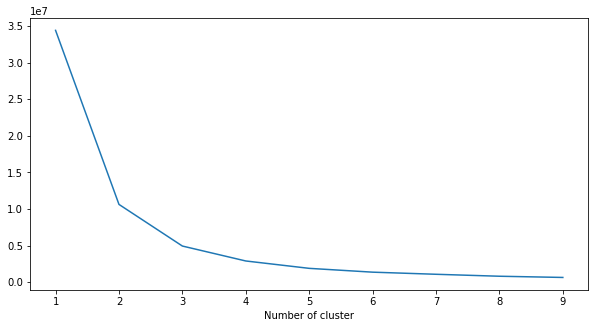

In [117]:
cluster_range=range(1,10)
sse=[]
freq = storeRFM[['Frequency']]
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(freq)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(cluster_range, sse)
plt.xlabel("Number of cluster")
plt.show()

Four clusters seems to be the optimum number of clusters.

In [118]:
# build three cluster and assign
kmeans = KMeans(n_clusters=4)
kmeans.fit(storeRFM[['Frequency']])
storeRFM['Frequency Cluster'] = kmeans.predict(storeRFM[['Frequency']])
storeRFM.head()

,Store Number,Recency,Recency Cluster,Frequency,Frequency Cluster
0,4116,11,2,60,0
1,4019,3,2,299,1
2,3456,1,2,608,2
3,3742,3,2,218,1
4,2528,1,2,286,1


In [119]:
storeRFM.groupby('Frequency Cluster')['Frequency'].agg(['count','mean','std']).reset_index()

,Frequency Cluster,count,mean,std
0,0,1324,26.153323,21.234142
1,1,212,284.688679,55.272245
2,2,84,545.452381,112.839091
3,3,459,129.394336,36.398919


In [124]:
# reorder the clusters ascendingly
storeRFM=order_cluster('Frequency Cluster', 'Frequency',storeRFM,True)

Frequency Segments:
<br>
0: Low Frequency
<br>
1: Lower-Medium Frequency
<br>
2: Higher-Medium Frequency
<br>
3: High Frequency    

In [127]:
storeRFM.groupby('Frequency Cluster')['Frequency'].agg(['count','mean','std']).reset_index()

,Frequency Cluster,count,mean,std
0,0,1324,26.153323,21.234142
1,1,459,129.394336,36.398919
2,2,212,284.688679,55.272245
3,3,84,545.452381,112.839091


#### Monetary
How much sales did each store contribute to the revenue of Titos?

In [58]:
storeM=TitosTrans.groupby('Store Number')['Sale (Dollars)'].sum().reset_index().rename(index=str,columns={'Sale (Dollars)':'Sales'})
storeM.head()

,Store Number,Sales
0,2106,232698.56
1,2113,12230.61
2,2130,184207.36
3,2152,35.76
4,2178,52216.11


Text(0.5, 1.0, 'Sales')

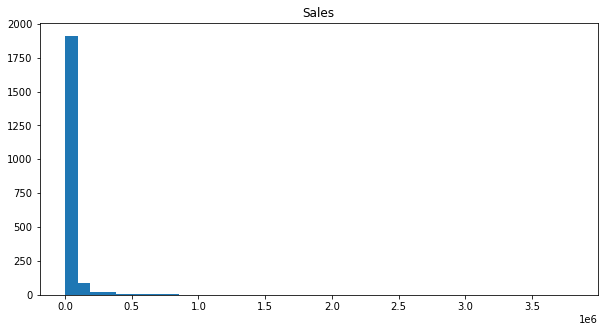

In [59]:
plt.hist(storeM['Sales'],bins=40)
plt.title('Sales')

In [60]:
storeM['Sales'].describe()

count    2.079000e+03
mean     3.729060e+04
std      1.489955e+05
min      8.130000e+00
25%      1.871340e+03
50%      6.018510e+03
75%      2.211372e+04
max      3.802490e+06
Name: Sales, dtype: float64

In [61]:
storeRFM=pd.merge(storeRFM,storeM,on='Store Number')

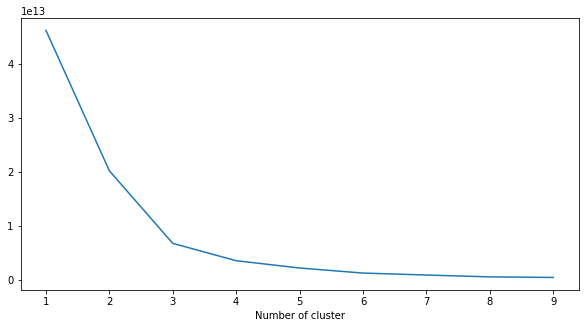

In [141]:
cluster_range=range(1,10)
sse=[]
sales = storeRFM[['Sales']]
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(sales)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(cluster_range, sse)
plt.xlabel("Number of cluster")
plt.show()

Four clusters seem to be the optimum choice.

In [144]:
# build three cluster and assign
kmeans = KMeans(n_clusters=4)
kmeans.fit(storeRFM[['Sales']])
storeRFM['Sales Cluster'] = kmeans.predict(storeRFM[['Sales']])
storeRFM.head()

,Store Number,Recency,Recency Cluster,Frequency,Frequency Cluster,Sales,Sales Cluster
0,4116,11,2,60,0,11165.04,0
1,4130,2,2,63,0,10663.98,0
2,5807,0,2,18,0,4990.14,0
3,5356,4,2,49,0,7854.84,0
4,5848,31,2,15,0,1894.60,0


In [149]:
storeRFM.groupby('Sales Cluster')['Sales'].agg(['count','mean','std']).reset_index()

,Sales Cluster,count,mean,std
0,0,1933,1.385408e+04,20629.317615
1,1,2,3.638725e+06,231599.101235
2,2,24,7.399608e+05,263784.828551
3,3,120,2.142559e+05,93680.884819


Sales Segments:
<br>
0: Low Sales
<br>
1: Lower-Medium Sales
<br>
2: Higher-Medium Sales
<br>
3: High Sales   

In [148]:
# reorder the clusters ascendingly
storeRFM=order_cluster('Sales Cluster', 'Sales',storeRFM,True)
storeRFM.groupby('Sales Cluster')['Sales'].agg(['count','mean','std']).reset_index()

,Sales Cluster,count,mean,std
0,0,1933,1.385408e+04,20629.317615
1,1,120,2.142559e+05,93680.884819
2,2,24,7.399608e+05,263784.828551
3,3,2,3.638725e+06,231599.101235


#### One-step clustering

After exploring the segments for each RFM, we are going to use one-step clustering for the customer segmentation.

In [62]:
OneStepRFM = storeRFM[['Store Number','Recency','Frequency','Sales']]
OneStepRFM.head()

,Store Number,Recency,Frequency,Sales
0,4116,11,60,11165.04
1,4019,3,299,68375.52
2,3456,1,608,182895.98
3,3742,3,218,48454.44
4,2528,1,286,213316.75


In [63]:
from sklearn.preprocessing import StandardScaler
# standardize RFM parameters to avoid the effect of the high variance difference in the three features
scaler = StandardScaler()
scaler.fit(OneStepRFM[['Recency','Frequency','Sales']])
standard=pd.DataFrame(scaler.transform(OneStepRFM[['Recency','Frequency','Sales']]),
                      columns=['StdRecency','StdFrequency','StdSales'])
standard.head()

,StdRecency,StdFrequency,StdSales
0,-0.393492,-0.282168,-0.175387
1,-0.409890,1.576044,0.208680
2,-0.413989,3.978502,0.977482
3,-0.409890,0.946273,0.074945
4,-0.413989,1.474969,1.181704


In [64]:
OneStepRFM=pd.concat([OneStepRFM,standard],axis=1)

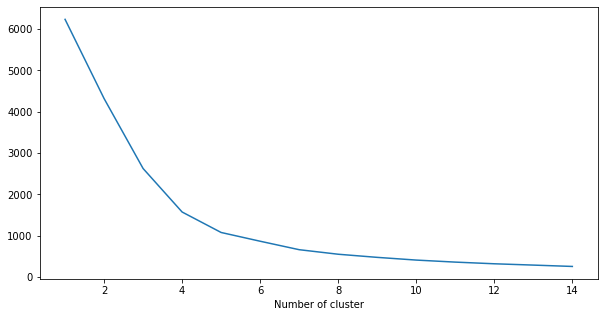

In [65]:
sse=[]
cluster_range=range(1,15)
rfm = OneStepRFM[['StdRecency','StdFrequency','StdSales']]
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(rfm)
    sse.append(kmeans.inertia_)
plt.figure()
plt.plot(cluster_range, sse)
plt.xlabel("Number of cluster")
plt.show()

Seven segments seems to be the optimum choice. However, there are outliars in the data and we don't want to over-segment the customers. We just want low, medium and high value customers.

In [66]:
# build three cluster and assign
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm)
storeRFM['1-step customer segment'] = kmeans.predict(rfm)
storeRFM.head()

,Store Number,Recency,Frequency,Sales,1-step customer segment
0,4116,11,60,11165.04,1
1,4019,3,299,68375.52,1
2,3456,1,608,182895.98,2
3,3742,3,218,48454.44,1
4,2528,1,286,213316.75,2


In [67]:
storeRFM.groupby('1-step customer segment')['Recency','Frequency','Sales'].agg(['count','mean','std']).reset_index()

<ipython-input-67-c308743c6f22>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  storeRFM.groupby('1-step customer segment')['Recency','Frequency','Sales'].agg(['count','mean','std']).reset_index()


1-step customer segment Recency                          Frequency  \
                            count         mean         std     count   
0                       0     208  1523.014423  537.797454       208   
1                       1    1705    60.639296  136.145340      1705   
2                       2     166    10.807229   38.684570       166   

                          Sales                                
         mean         std count           mean            std  
0   22.052885   34.585916   208    3267.797837    7426.436220  
1   71.743695   72.991426  1705   15208.479783   24085.826423  
2  441.451807  137.417636   166  306728.844578  440438.318547

Text(0.5, 0, 'Sales')

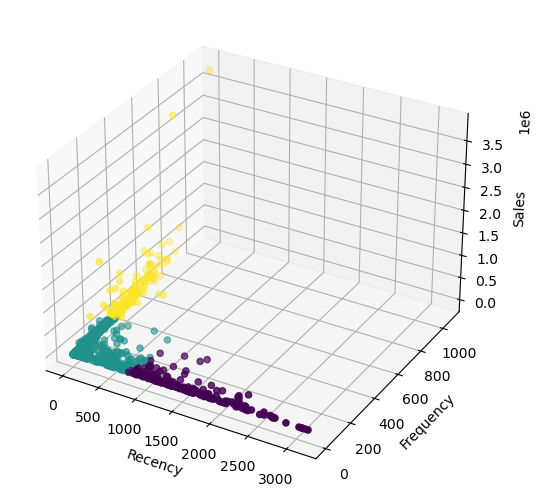

In [68]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update(plt.rcParamsDefault)
fig = plt.figure()
ax=Axes3D(fig)
ax.scatter(storeRFM['Recency'],storeRFM['Frequency'],storeRFM['Sales'],
           c=storeRFM['1-step customer segment'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Sales')


In [69]:
# create a column for customer segments
conditions = [
    (storeRFM['1-step customer segment'] == 0),
    (storeRFM['1-step customer segment'] == 1),
    (storeRFM['1-step customer segment'] == 2)
    ]

# create a list of the values we want to assign for each condition
values = ['Low', 'Medium', 'High']

storeRFM['Store Segment']=np.select(conditions, values)

In [70]:
storeRFM.head()

,Store Number,Recency,Frequency,Sales,1-step customer segment,Store Segment
0,4116,11,60,11165.04,1,Medium
1,4019,3,299,68375.52,1,Medium
2,3456,1,608,182895.98,2,High
3,3742,3,218,48454.44,1,Medium
4,2528,1,286,213316.75,2,High


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Frequency', ylabel='Sales'>

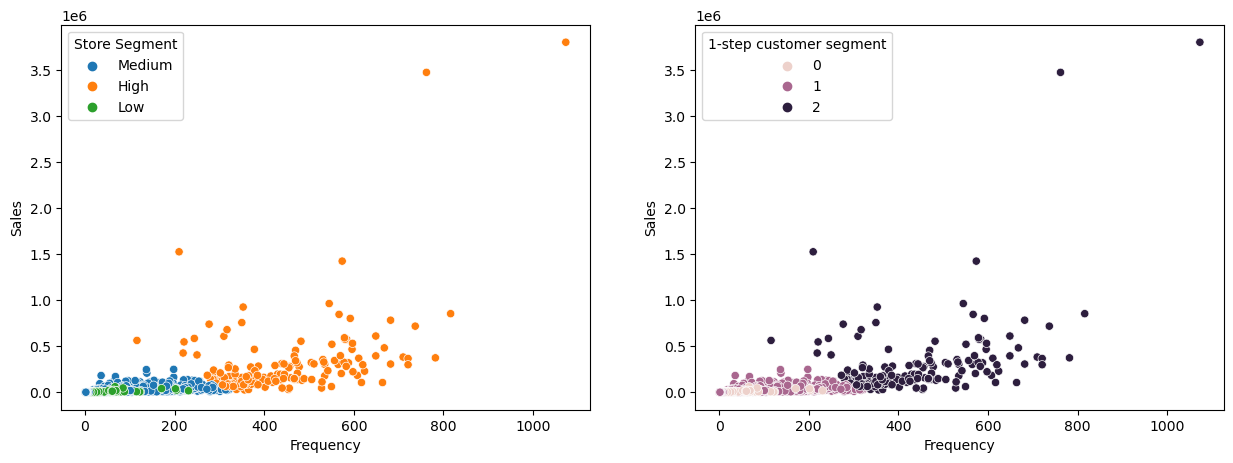

In [71]:
# to make sure naming went right
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(1,2,1)
sns.scatterplot(storeRFM['Frequency'],storeRFM['Sales'],hue=storeRFM['Store Segment'])
plt.subplot(1,2,2)
sns.scatterplot(storeRFM['Frequency'],storeRFM['Sales'],hue=storeRFM['1-step customer segment'])

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Recency', ylabel='Sales'>

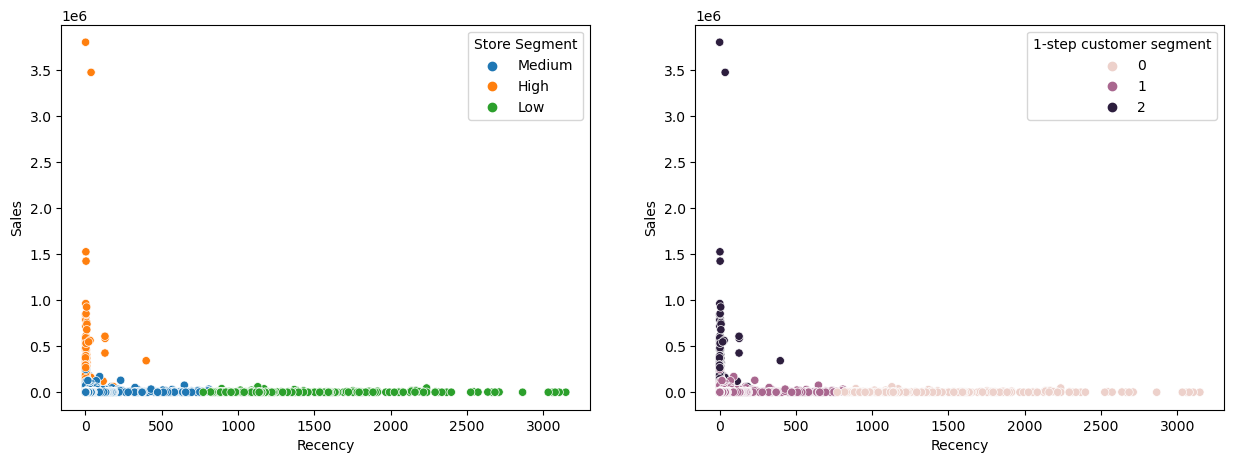

In [72]:
plt.subplot(1,2,1)
sns.scatterplot(storeRFM['Recency'],storeRFM['Sales'],hue=storeRFM['Store Segment'])
plt.subplot(1,2,2)
sns.scatterplot(storeRFM['Recency'],storeRFM['Sales'],hue=storeRFM['1-step customer segment'])

In [73]:
storeRFM.drop(['1-step customer segment'],axis=1,inplace=True)
storeRFM.head()

,Store Number,Recency,Frequency,Sales,Store Segment
0,4116,11,60,11165.04,Medium
1,4019,3,299,68375.52,Medium
2,3456,1,608,182895.98,High
3,3742,3,218,48454.44,Medium
4,2528,1,286,213316.75,High


In [75]:
db = sqlite3.connect("ItemTrans.sqlite")
ItemTrans.to_sql("ItemTrans",db,if_exists='replace', chunksize=1000,index=False)

C:\Users\Ibrahim\anaconda3\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [76]:
# titos store segments
db = sqlite3.connect("TitosStoreSegments.sqlite")
storeRFM.to_sql("TitosStoreSegments",db,if_exists='replace', chunksize=1000,index=False)

#### Low Store Segment
Analyze the competition in the low-value segment 

In [7]:
conn=sqlite3.connect("ItemTrans.sqlite")
ItemTrans=pd.read_sql('SELECT * FROM ItemTrans', conn)
ItemTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
0,2016-03-16 00:00:00,Liqueur,ryans cream liqueur,10.85,1.0,S31296100034,3762,wine and spirits gallery
1,2019-07-15 00:00:00,ImportWhiskies,scoresby rare scotch,94.50,10.5,INV-20599500022,4320,fareway stores 470 perry
2,2020-07-01 00:00:00,ImportWhiskies,jameson,97.44,3.5,INV-28403900139,2643,hy vee wine and spirits waterloo
3,2019-07-11 00:00:00,ImportWhiskies,scoresby rare scotch,20.22,2.0,INV-20560900100,3456,quick shop clear lake
4,2019-07-23 00:00:00,Specialty,captain morgan osr glass w50ml apple smash 50...,162.00,11.1,INV-20784900043,5151,ida liquor


In [8]:
conn=sqlite3.connect("TitosStoreSegments.sqlite")
storeRFM=pd.read_sql('SELECT * FROM TitosStoreSegments', conn)
storeRFM.head()

,Store Number,Recency,Frequency,Sales,Store Segment
0,4116,11,60,11165.04,Medium
1,4019,3,299,68375.52,Medium
2,3456,1,608,182895.98,High
3,3742,3,218,48454.44,Medium
4,2528,1,286,213316.75,High


In [77]:
# Get store numbers in the Low segment category
LowStores=storeRFM[storeRFM['Store Segment']=='Low']['Store Number']
LowStores.shape

(208,)

In [78]:
LowStoresTrans=ItemTrans[ItemTrans['Store Number'].isin(LowStores)]
LowStoresTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
0,2016-03-16,Liqueur,ryans cream liqueur,10.85,1.00,S31296100034,3762,wine and spirits gallery
60,2016-03-21,USVodka,outerspace,67.50,2.25,S31327800007,4222,station mart liquor and tobacco
148,2016-03-22,USRum,captain morgan spiced rum,180.00,9.00,S31360800027,4176,todds on the go
609,2016-03-30,Tequila,juarez tequila silver,249.12,24.00,S31510600002,3584,l and m beverage
656,2016-03-30,USGin,paramount gin,61.20,9.00,S31524800036,3772,shop n save 1 mlk pkwy


In [79]:
LowStoresTrans.shape

(1368967, 8)

In [80]:
# top 10 brand purchases for Low sigment stores
TopItemsLowStores=LowStoresTrans[['Item Description','Volume Sold (Liters)']].groupby(['Item Description']).sum().sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:10]

In [81]:
TopItemsLowStores

,Volume Sold (Liters)
Item Description,
black velvet,587664.85
hawkeye vodka,430207.58
captain morgan spiced rum,287320.71
five oclock vodka,273514.08
mccormick vodka pet,166060.09
jack daniels old 7 black lbl,154691.10
barton vodka,152453.10
fireball cinnamon whiskey,150923.09
canadian ltd whisky,130804.12


In [82]:
TopTransLowStores=LowStoresTrans[LowStoresTrans['Item Description'].isin(TopItemsLowStores.index)]

In [83]:
TopTransLowStores.shape

(187947, 8)

In [291]:
TopTransLowStores['Date']= pd.to_datetime(TopTransLowStores['Date'])

<ipython-input-291-365f7e6d9502>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TopTransLowStores['Date']= pd.to_datetime(TopTransLowStores['Date'])


In [84]:
MonthlySalesLowStores=TopTransLowStores.groupby(['Item Description',pd.Grouper(key='Date', freq='M')]).sum().reset_index()
MonthlySalesLowStores.head()

,Item Description,Date,Sale (Dollars),Volume Sold (Liters),Store Number
0,barton vodka,2012-01-31,15627.44,2620.50,518234
1,barton vodka,2012-02-29,16114.39,2704.75,525260
2,barton vodka,2012-03-31,16404.22,2754.87,489559
3,barton vodka,2012-04-30,18200.54,3057.25,592886
4,barton vodka,2012-05-31,19371.16,3253.87,691742


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim

Text(0.5, 1.0, 'PLC of Top 10 Brands (Low Store Segment)')

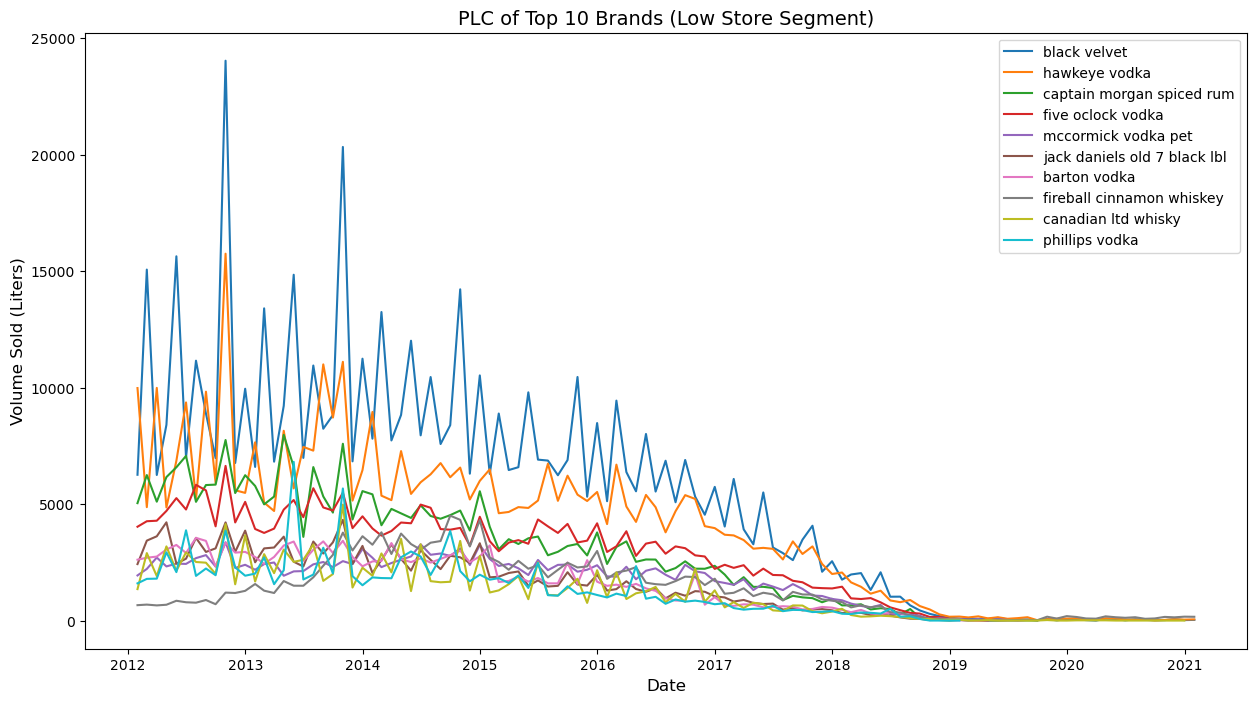

In [85]:
plt.rcParams['figure.figsize'] = (15,8)
for i in range(0,10,1):
    ItemVolSales=MonthlySalesLowStores[MonthlySalesLowStores['Item Description']==TopItemsLowStores.index[i]]
    #sns.lineplot(ItemVolSales.Date.dt.strftime('%Y-%m-%d'),ItemVolSales['Volume Sold (Liters)'],
     #            label=topbrands.index[i]).set_xticklabels(labels= ItemVolSales.Date.dt.strftime('%Y-%m-%d'),
      #                                                     rotation=90, ha='right')
    fig=sns.lineplot(ItemVolSales.Date,ItemVolSales['Volume Sold (Liters)'],label=TopItemsLowStores.index[i])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('PLC of Top 10 Brands (Low Store Segment)',fontsize=14)

In [301]:
LowStoresTrans['Date']= pd.to_datetime(LowStoresTrans['Date'])

<ipython-input-301-f7177d166282>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LowStoresTrans['Date']= pd.to_datetime(LowStoresTrans['Date'])


In [86]:
# Total Volume purchased by low Segment Stores
AggrMonthlyLowStoresTrans=LowStoresTrans[['Date','Volume Sold (Liters)']].groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Total Monthly Sale-Volume (Low Store Segment)')

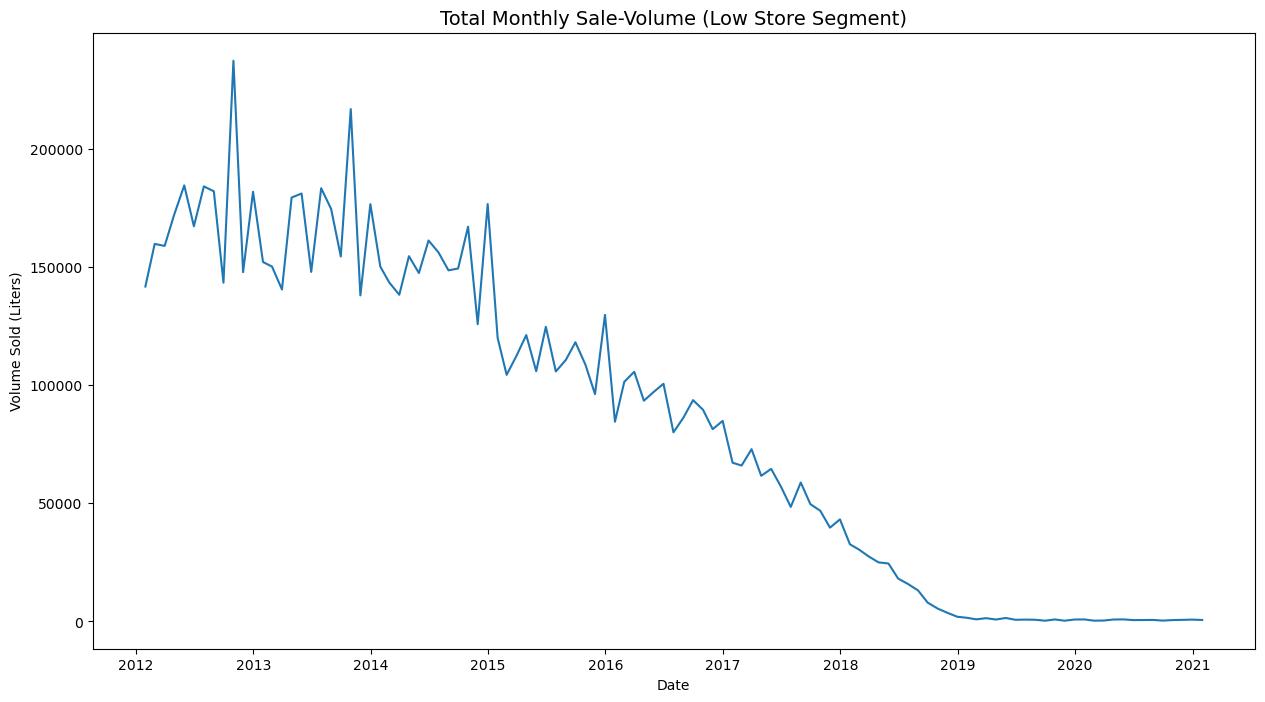

In [87]:
fig=sns.lineplot(AggrMonthlyLowStoresTrans.Date,AggrMonthlyLowStoresTrans['Volume Sold (Liters)'])
fig.set_title('Total Monthly Sale-Volume (Low Store Segment)',fontsize=14)

In [96]:
TopLowStores=LowStoresTrans[['Store Number','Store Name','Volume Sold (Liters)']].groupby(['Store Number','Store Name']).sum()

In [97]:
TopLowStores.sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:20]

,,Volume Sold (Liters)
Store Number,Store Name,
3692,wilkie liquors,457334.15
3926,liquor downtown iowa city,456162.07
2599,hy vee wine and spirits coralville,409249.24
2413,beecher beverage,282390.96
2564,hy vee food store 4 waterloo,277651.48
3573,quik shop foods four m in,188441.27
2290,als liquors unlimited,178393.27
2353,cresco liquor store,173488.14
4615,north side liquor grocery,138046.59


In [94]:
#StoreCounts=LowStoresTrans[['Date','Store Number']].groupby(pd.Grouper(key='Date', freq='M')).count().reset_index()

In [95]:
#fig=sns.lineplot(StoreCounts.Date,StoreCounts['Store Number'])
#fig.set_xlabel('Date',fontsize=12)
#fig.set_ylabel("Number of Stores",fontsize=12)
#fig.set_title('Number of Monthly Stores (Low Store Segment)',fontsize=14)

In [90]:
#TitosLowStoresTrans=LowStoresTrans[LowStoresTrans['Item Description']=='titos handmade vodka']

In [91]:
TitosAggrMonthlyLowStoresTrans=TitosLowStoresTrans[['Date','Volume Sold (Liters)']].groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Titos Vodka Monthly Sale-Volume (Low Store Segment)')

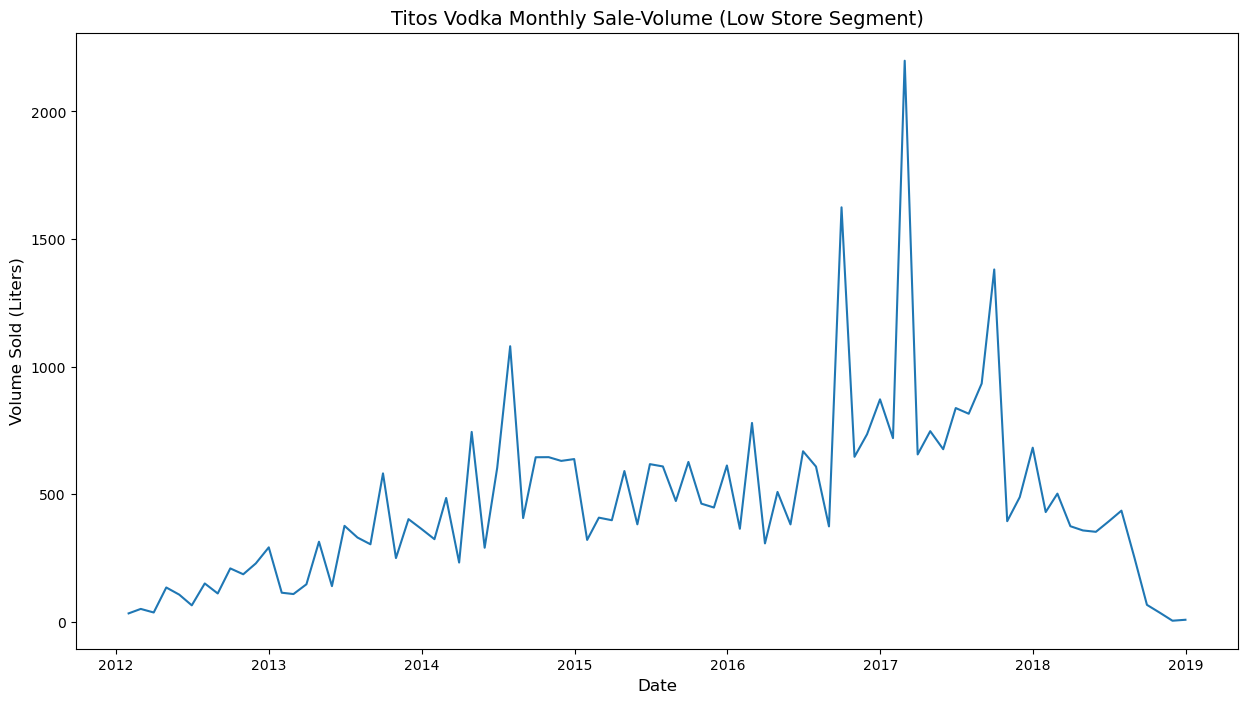

In [92]:
fig=sns.lineplot(TitosAggrMonthlyLowStoresTrans.Date,TitosAggrMonthlyLowStoresTrans['Volume Sold (Liters)'])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('Titos Vodka Monthly Sale-Volume (Low Store Segment)',fontsize=14)

In [93]:
TitosLowStoresTrans['Store Number'].unique().shape

(208,)

#### Medium Segment
Repeat the same process

In [9]:
# Get store numbers in the Low segment category
MedStores=storeRFM[storeRFM['Store Segment']=='Medium']['Store Number']
MedStores.shape

(1705,)

In [52]:
#ItemTrans.drop('index',axis=1,inplace=True)

In [10]:
ItemTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
0,2016-03-16 00:00:00,Liqueur,ryans cream liqueur,10.85,1.0,S31296100034,3762,wine and spirits gallery
1,2019-07-15 00:00:00,ImportWhiskies,scoresby rare scotch,94.50,10.5,INV-20599500022,4320,fareway stores 470 perry
2,2020-07-01 00:00:00,ImportWhiskies,jameson,97.44,3.5,INV-28403900139,2643,hy vee wine and spirits waterloo
3,2019-07-11 00:00:00,ImportWhiskies,scoresby rare scotch,20.22,2.0,INV-20560900100,3456,quick shop clear lake
4,2019-07-23 00:00:00,Specialty,captain morgan osr glass w50ml apple smash 50...,162.00,11.1,INV-20784900043,5151,ida liquor


In [11]:
MedStoresTrans=ItemTrans[ItemTrans['Store Number'].isin(MedStores)]
MedStoresTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
1,2019-07-15 00:00:00,ImportWhiskies,scoresby rare scotch,94.5,10.5,INV-20599500022,4320,fareway stores 470 perry
4,2019-07-23 00:00:00,Specialty,captain morgan osr glass w50ml apple smash 50...,162.0,11.1,INV-20784900043,5151,ida liquor
5,2019-07-02 00:00:00,Specialty,captain morgan osr glass w50ml apple smash 50...,324.0,22.2,INV-20359100039,5151,ida liquor
6,2019-07-23 00:00:00,Specialty,captain morgan w50ml cannonblast loconut,162.0,11.1,INV-20784900042,5151,ida liquor
8,2019-07-23 00:00:00,Specialty,jim beam wshot pilsner glass,94.5,4.5,INV-20780800005,3993,new star liquor w 4th s waterloo


In [101]:
#MedStoresTrans['Date']= pd.to_datetime(MedStoresTrans['Date'])

In [102]:
# Total Volume purchased by Med Segment Stores
AggrMonthlyMedStoresTrans=MedStoresTrans[['Date','Volume Sold (Liters)']].groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Total Monthly Sale-Volume (Medium Store Segment)')

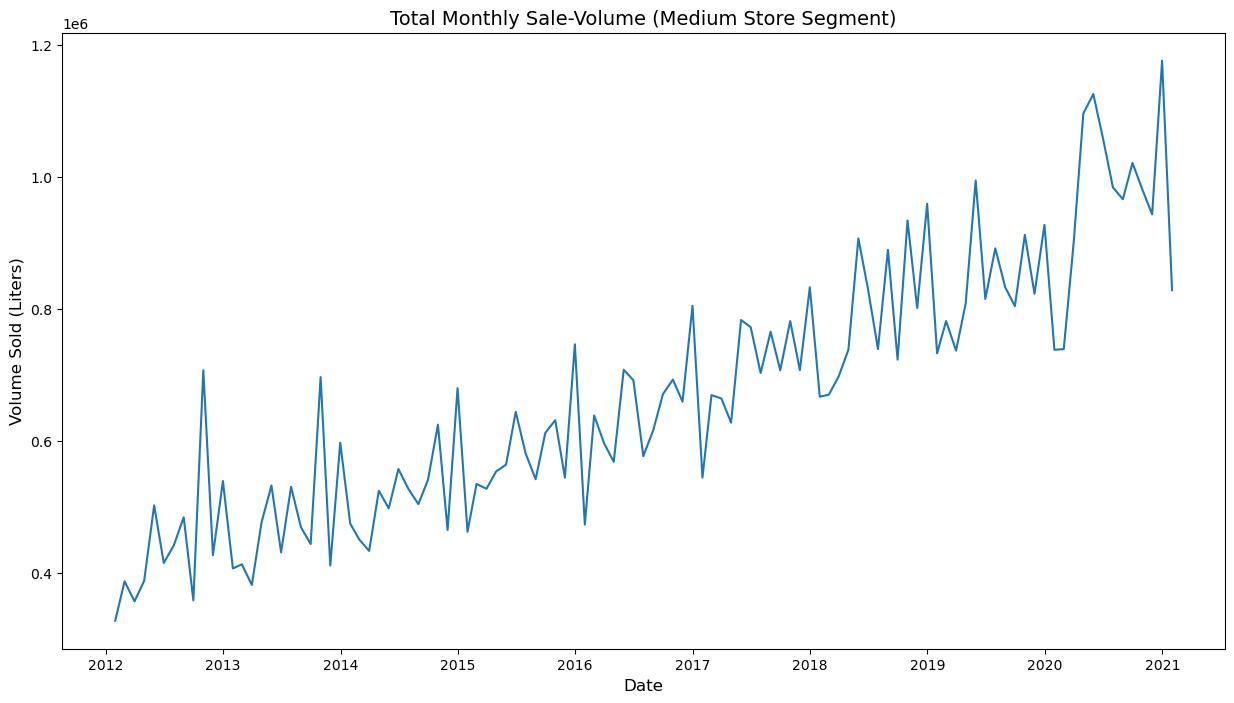

In [104]:
fig= sns.lineplot(AggrMonthlyMedStoresTrans.Date,AggrMonthlyMedStoresTrans['Volume Sold (Liters)'])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('Total Monthly Sale-Volume (Medium Store Segment)',fontsize=14)

In [105]:
TopMedStores=MedStoresTrans[['Store Number','Store Name','Volume Sold (Liters)']].groupby(['Store Number','Store Name']).sum()

In [106]:
TopMedStores.sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:20]

,,Volume Sold (Liters)
Store Number,Store Name,
2595,hy vee wine and spirits denison,511486.28
2585,hy vee wine and spirits algona,446746.84
2591,hy vee wine and spirits atlantic,427685.07
2555,hy vee food store keokuk,425975.57
3618,wal mart 2716 cedar rapids,382273.77
2606,hy vee wine and spirits humboldt,380081.91
3443,super saver iv,372195.68
2652,hy vee drugstore mason city,357206.41
2607,hy vee wine and spirits shenandoah,321027.93


The top stores in this medium categories are super stores like Hy-Vee and Walmart. Hy-Vee is a popular super store in the midwesern states Iowa, Illinois, Kansas, Minnesota, Missouri, Nebraska, South Dakota, and Wisconsin. 

In [107]:
TopItemsMedStores=MedStoresTrans[['Item Description','Volume Sold (Liters)']].groupby(['Item Description']).sum().sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:10]

In [108]:
TopItemsMedStores

,Volume Sold (Liters)
Item Description,
black velvet,6.912165e+06
hawkeye vodka,4.424751e+06
five oclock vodka,2.435991e+06
titos handmade vodka,1.440782e+06
fireball cinnamon whiskey,1.385680e+06
captain morgan spiced rum,1.368178e+06
admiral nelson spiced rum,1.230692e+06
mccormick vodka pet,1.059429e+06
canadian ltd whisky,1.011818e+06


In [109]:
TopTransMedStores=MedStoresTrans[MedStoresTrans['Item Description'].isin(TopItemsMedStores.index)]

In [110]:
TopTransMedStores.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
12,2020-11-02,ImportWhiskies,black velvet,119.40,12.0,INV-31573500023,3696,wal mart 1723 des moines
32,2020-02-03,USRum,captain morgan original spiced,180.00,9.0,INV-24976700011,4640,mart stop 1 davenport
40,2020-02-03,USVodka,titos handmade vodka,171.00,10.5,INV-24978400002,4116,lake view foods
74,2020-02-04,USVodka,hawkeye vodka,64.56,10.5,INV-24996200048,5444,marshall beer wine spirits
84,2019-07-12,ImportWhiskies,black velvet,110.64,9.0,INV-20585200005,3461,hometown foods stuart


In [111]:
MonthlySalesMedStores=TopTransMedStores.groupby(['Item Description',pd.Grouper(key='Date', freq='M')]).sum().reset_index()
MonthlySalesMedStores.head()

,Item Description,Date,Sale (Dollars),Volume Sold (Liters),Store Number
0,admiral nelson spiced rum,2012-01-31,38654.98,3640.46,1312103
1,admiral nelson spiced rum,2012-02-29,86125.74,8316.60,2912965
2,admiral nelson spiced rum,2012-03-31,67465.39,6464.88,2526251
3,admiral nelson spiced rum,2012-04-30,63162.43,6031.11,2636708
4,admiral nelson spiced rum,2012-05-31,91536.68,8796.86,3107756


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim

Text(0.5, 1.0, 'PLC of Top 10 Brands (Medium Store Segment)')

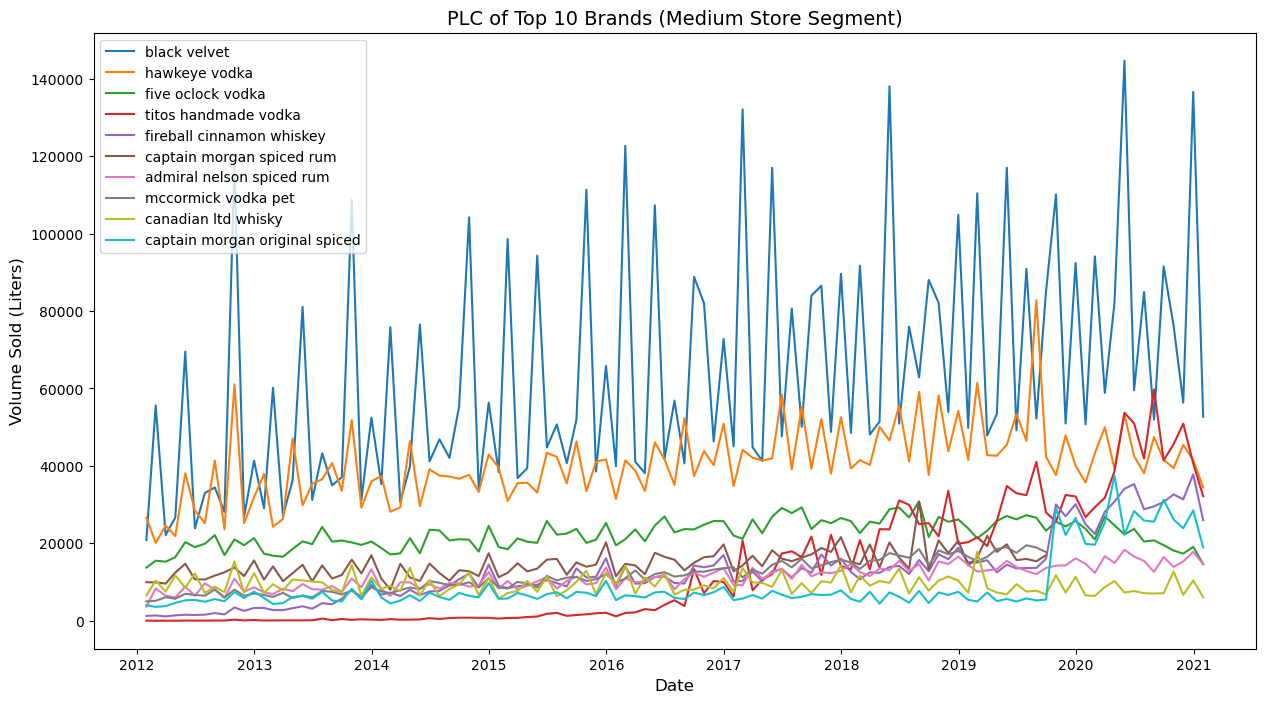

In [112]:
plt.rcParams['figure.figsize'] = (15,8)
for i in range(0,10,1):
    ItemVolSales=MonthlySalesMedStores[MonthlySalesMedStores['Item Description']==TopItemsMedStores.index[i]]
    #sns.lineplot(ItemVolSales.Date.dt.strftime('%Y-%m-%d'),ItemVolSales['Volume Sold (Liters)'],
     #            label=topbrands.index[i]).set_xticklabels(labels= ItemVolSales.Date.dt.strftime('%Y-%m-%d'),
      #                                                     rotation=90, ha='right')
    fig=sns.lineplot(ItemVolSales.Date,ItemVolSales['Volume Sold (Liters)'],label=TopItemsMedStores.index[i])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('PLC of Top 10 Brands (Medium Store Segment)',fontsize=14)

Titos and Hawkey are main competitiors. Titos needs to come up with a marketing plan to beat the competitions. To help to come up with a marketing plan, I'm doing Market Basket Analysis.

In [12]:
MedStoresTrans['Invoice/Item Number'].unique().shape

(9702409,)

In [13]:
MedStoresTrans.shape

(9702409, 8)

In [14]:
MedStoresTrans['Date'].unique().shape

(2170,)

In [17]:
MedStoresTrans['Date']= pd.to_datetime(MedStoresTrans['Date'])

<ipython-input-17-6315f4c6685d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MedStoresTrans['Date']= pd.to_datetime(MedStoresTrans['Date'])


In [18]:
MedStoresTrans['Date'].dtype

dtype('<M8[ns]')

In [19]:
#MedStoresTrans['Item Description'].unique().shape

For an up-to-date MBA, only transactions starting from 2020 will be used for MBA

In [20]:
MedStoresTrans2020=MedStoresTrans[MedStoresTrans['Date'] >= '2020-01-01']
MedStoresTrans2020.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
12,2020-11-02,ImportWhiskies,black velvet,119.40,12.00,INV-31573500023,3696,wal mart 1723 des moines
27,2020-02-03,ImportWhiskies,crown royal regal apple,36.00,1.12,INV-24974300009,5597,liquor tobacco gas
31,2020-11-02,Liqueur,kahlua coffee,224.88,9.00,INV-31583800002,3749,wal mart 1526 storm lake
32,2020-02-03,USRum,captain morgan original spiced,180.00,9.00,INV-24976700011,4640,mart stop 1 davenport
33,2020-07-01,USWhiskies,jim beam,189.00,10.50,INV-28415300023,3626,wal mart 2714 spencer


In [119]:
MedStoresTrans2020.shape

(1707705, 8)

In [120]:
MedStoresTrans2020['Date'].unique().shape

(283,)

In [121]:
MedStoresTrans2020['Item Description'].unique().shape

(2890,)

In [122]:
MedStoresTrans2020['Store Number'].unique().shape

(1636,)

In [124]:
#MedStoresTrans2020.drop('index',axis=1,inplace=True)

In [21]:
# strip the item number from the invoice/item number so that the invoice number is store and date specific
MedStoresTrans2020.iloc[0,5][0:10]

'INV-315735'

In [22]:
MedStoresTrans2020['Invoice Number']=[text[0:10] for text in MedStoresTrans2020['Invoice/Item Number']]

<ipython-input-22-91f6dbe45450>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MedStoresTrans2020['Invoice Number']=[text[0:10] for text in MedStoresTrans2020['Invoice/Item Number']]


In [23]:
#The total number of transactions
MedStoresTrans2020['Invoice Number'].unique().shape

(70161,)

In [128]:
# make sure that each transaction has one date and one store
MedStoresTrans2020[['Invoice Number','Date','Store Number','Item Description']].groupby(['Invoice Number','Date','Store Number']).count().reset_index()

,Invoice Number,Date,Store Number,Item Description
0,INV-242892,2020-01-02,5098,3
1,INV-242893,2020-01-02,3842,7
2,INV-242895,2020-01-02,4511,8
3,INV-242896,2020-01-02,5722,6
4,INV-242897,2020-01-02,2627,2
...,...,...,...,...
70156,INV-339121,2021-01-29,5632,2
70157,INV-339122,2021-01-29,5005,33
70158,INV-339123,2021-01-29,3964,28
70159,INV-339124,2021-01-29,5157,31


The number of rows matches the number of invoices. Each invoice number has exactly one store and one date.

In [129]:
MedStoresTrans2020.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name,Invoice Number
12,2020-11-02,ImportWhiskies,black velvet,119.40,12.00,INV-31573500023,3696,wal mart 1723 des moines,INV-315735
27,2020-02-03,ImportWhiskies,crown royal regal apple,36.00,1.12,INV-24974300009,5597,liquor tobacco gas,INV-249743
31,2020-11-02,Liqueur,kahlua coffee,224.88,9.00,INV-31583800002,3749,wal mart 1526 storm lake,INV-315838
32,2020-02-03,USRum,captain morgan original spiced,180.00,9.00,INV-24976700011,4640,mart stop 1 davenport,INV-249767
33,2020-07-01,USWhiskies,jim beam,189.00,10.50,INV-28415300023,3626,wal mart 2714 spencer,INV-284153


In [24]:
basket = (MedStoresTrans2020[['Invoice Number','Item Description','Volume Sold (Liters)']]
          .groupby(['Invoice Number', 'Item Description'])['Volume Sold (Liters)']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice Number'))

In [25]:
# invoice number and item numbers match
basket.shape

(70161, 2890)

In [132]:
basket.head()

Item Description,135° east hyogo japanese dry gin,135� east hyogo japanese dry gin,1792 12yr old bourbon,1792 bottle in bond bourbon,1792 bottled in bond bourbon,1792 full proof,1792 single barrel,1792 single barrel bourbon,1792 sweet wheat bourbon,1800 anejo,...,yellowstone limited edition 2020,yellowstone select,yellowstone select barrel program,yukon jack,yukon jack fire,yukon jack honey,yukon jack jacapple,yukon jack perma frost,zaya gran reserva rum,zaya gran reserva rum wice ball tray
Invoice Number,,,,,,,,,,,,,,,,,,,,,
INV-242892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INV-242893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INV-242895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INV-242896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INV-242897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# encoding function, 0 if no sales, 1 if sales
def encode_units(x):
    if x <= 0.0:
        return 0.0
    if x >= 0.0:
        return 1.0

In [27]:
basket_sets = basket.applymap(encode_units).astype(int)

In [28]:
basket_sets.isna().sum().sum()

0

In [29]:
basket_sets.head()

Item Description,135° east hyogo japanese dry gin,135� east hyogo japanese dry gin,1792 12yr old bourbon,1792 bottle in bond bourbon,1792 bottled in bond bourbon,1792 full proof,1792 single barrel,1792 single barrel bourbon,1792 sweet wheat bourbon,1800 anejo,...,yellowstone limited edition 2020,yellowstone select,yellowstone select barrel program,yukon jack,yukon jack fire,yukon jack honey,yukon jack jacapple,yukon jack perma frost,zaya gran reserva rum,zaya gran reserva rum wice ball tray
Invoice Number,,,,,,,,,,,,,,,,,,,,,
INV-242892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INV-242893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INV-242895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INV-242896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INV-242897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [31]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

In [32]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(absolut swedish vodka 80prf),(black velvet),0.187497,0.492168,0.124870,0.665983,1.353161,0.032590,1.520375
1,(absolut swedish vodka 80prf),(captain morgan original spiced),0.187497,0.332963,0.094725,0.505207,1.517308,0.032295,1.348114
2,(absolut swedish vodka 80prf),(fireball cinnamon whiskey),0.187497,0.388777,0.105685,0.563664,1.449838,0.032791,1.400808
3,(absolut swedish vodka 80prf),(hawkeye vodka),0.187497,0.391728,0.103961,0.554466,1.415438,0.030513,1.365266
4,(absolut swedish vodka 80prf),(titos handmade vodka),0.187497,0.419450,0.118029,0.629494,1.500763,0.039383,1.566914


In [33]:
# create columns for the lengths of antecedents and consequents sets
rules['ante length']=rules["antecedents"].apply(lambda x: len(x))
rules['conseq length']=rules["consequents"].apply(lambda x: len(x))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante length,conseq length
0,(absolut swedish vodka 80prf),(black velvet),0.187497,0.492168,0.124870,0.665983,1.353161,0.032590,1.520375,1,1
1,(absolut swedish vodka 80prf),(captain morgan original spiced),0.187497,0.332963,0.094725,0.505207,1.517308,0.032295,1.348114,1,1
2,(absolut swedish vodka 80prf),(fireball cinnamon whiskey),0.187497,0.388777,0.105685,0.563664,1.449838,0.032791,1.400808,1,1
3,(absolut swedish vodka 80prf),(hawkeye vodka),0.187497,0.391728,0.103961,0.554466,1.415438,0.030513,1.365266,1,1
4,(absolut swedish vodka 80prf),(titos handmade vodka),0.187497,0.419450,0.118029,0.629494,1.500763,0.039383,1.566914,1,1


In [34]:
# pick association rules that have one antecedent and one cosequent
#rules1=rules[ (rules['ante length']==1) &
#            (rules['conseq length']==1)]

In [35]:
# convert frozensets into string
rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x)).astype("unicode")
rules["consequents"] = rules["consequents"].apply(lambda x: list(x)).astype("unicode")
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante length,conseq length
0,['absolut swedish vodka 80prf'],['black velvet'],0.187497,0.492168,0.124870,0.665983,1.353161,0.032590,1.520375,1,1
1,['absolut swedish vodka 80prf'],['captain morgan original spiced'],0.187497,0.332963,0.094725,0.505207,1.517308,0.032295,1.348114,1,1
2,['absolut swedish vodka 80prf'],['fireball cinnamon whiskey'],0.187497,0.388777,0.105685,0.563664,1.449838,0.032791,1.400808,1,1
3,['absolut swedish vodka 80prf'],['hawkeye vodka'],0.187497,0.391728,0.103961,0.554466,1.415438,0.030513,1.365266,1,1
4,['absolut swedish vodka 80prf'],['titos handmade vodka'],0.187497,0.419450,0.118029,0.629494,1.500763,0.039383,1.566914,1,1


In [36]:
rules.iloc[0,1]

"['black velvet']"

In [37]:
rules[rules['consequents']=="['titos handmade vodka']"].sort_values(by='confidence',ascending=False)[0:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,ante length,conseq length
507,"['jim beam', 'black velvet', 'captain morgan o...",['titos handmade vodka'],0.094739,0.41945,0.070395,0.743042,1.771469,0.030657,2.259320,3,1
512,"['black velvet', 'captain morgan original spic...",['titos handmade vodka'],0.103091,0.41945,0.075982,0.737039,1.757157,0.032741,2.207740,3,1
477,"['jim beam', 'smirnoff 80prf']",['titos handmade vodka'],0.097775,0.41945,0.071250,0.728717,1.737318,0.030239,2.140019,2,1
535,"['black velvet', 'hawkeye vodka', 'smirnoff 80...",['titos handmade vodka'],0.111273,0.41945,0.080814,0.726271,1.731487,0.034141,2.120897,3,1
485,"['black velvet', 'captain morgan original spic...",['titos handmade vodka'],0.107738,0.41945,0.078092,0.724831,1.728054,0.032901,2.109798,3,1
530,"['jim beam', 'black velvet', 'hawkeye vodka']",['titos handmade vodka'],0.101752,0.41945,0.073289,0.720269,1.717177,0.030609,2.075388,3,1
527,"['fireball cinnamon whiskey', 'black velvet', ...",['titos handmade vodka'],0.101452,0.41945,0.072889,0.718460,1.712864,0.030335,2.062055,3,1
327,"['black velvet', 'new amsterdam 80prf']",['titos handmade vodka'],0.106013,0.41945,0.075598,0.713095,1.700073,0.031130,2.023493,2,1
383,"['jim beam', 'captain morgan original spiced']",['titos handmade vodka'],0.122632,0.41945,0.087413,0.712808,1.699389,0.035975,2.021471,2,1
541,"['fireball cinnamon whiskey', 'captain morgan ...",['titos handmade vodka'],0.105928,0.41945,0.075198,0.709903,1.692464,0.030767,2.001230,3,1


In [38]:
HawTop10Rules=rules[rules['consequents']=="['hawkeye vodka']"].sort_values(by='confidence',ascending=False)[0:10]

In [39]:
length=range(0,10,1)
for i in length:
    ant=HawTop10Rules.iloc[i,0]
    conf=HawTop10Rules.iloc[i,5]
    print(ant,'-->','Hawkeye Vodka')
    print('Confidence=',conf)
    print('---------------------------------------------')

['black velvet', 'admiral nelson spiced rum', 'titos handmade vodka'] --> Hawkeye Vodka
Confidence= 0.7035891920957118
---------------------------------------------
['black velvet', 'titos handmade vodka', 'smirnoff 80prf'] --> Hawkeye Vodka
Confidence= 0.6943423952975754
---------------------------------------------
['black velvet', 'captain morgan original spiced', 'smirnoff 80prf'] --> Hawkeye Vodka
Confidence= 0.681045209456657
---------------------------------------------
['black velvet', 'new amsterdam 80prf'] --> Hawkeye Vodka
Confidence= 0.6708792686205969
---------------------------------------------
['jim beam', 'black velvet', 'titos handmade vodka'] --> Hawkeye Vodka
Confidence= 0.6707539786068354
---------------------------------------------
['admiral nelson spiced rum', 'captain morgan original spiced'] --> Hawkeye Vodka
Confidence= 0.6655749210433969
---------------------------------------------
['admiral nelson spiced rum', 'titos handmade vodka'] --> Hawkeye Vodka
Conf

Black Velvet is very dominant and included in the top 10 baskets. It will be removed from the MBA to avoid the noise.

In [40]:
basket_sets.drop('black velvet',axis=1,inplace=True)

In [41]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

In [42]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
# create columns for the lengths of antecedents and consequents sets
rules['ante length']=rules["antecedents"].apply(lambda x: len(x))
rules['conseq length']=rules["consequents"].apply(lambda x: len(x))
# convert frozensets into string
rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x)).astype("unicode")
rules["consequents"] = rules["consequents"].apply(lambda x: list(x)).astype("unicode")
HawTop10Rules=rules[rules['consequents']=="['hawkeye vodka']"].sort_values(by='confidence',ascending=False)[0:10]
length=range(0,10,1)
for i in length:
    ant=HawTop10Rules.iloc[i,0]
    conf=HawTop10Rules.iloc[i,5]
    print(ant,'-->','Hawkeye Vodka')
    print('Confidence=',conf)
    print('---------------------------------------------')

['admiral nelson spiced rum', 'captain morgan original spiced'] --> Hawkeye Vodka
Confidence= 0.6655749210433969
---------------------------------------------
['admiral nelson spiced rum', 'titos handmade vodka'] --> Hawkeye Vodka
Confidence= 0.6583986506597878
---------------------------------------------
['titos handmade vodka', 'smirnoff 80prf'] --> Hawkeye Vodka
Confidence= 0.6524867917653489
---------------------------------------------
['fireball cinnamon whiskey', 'admiral nelson spiced rum'] --> Hawkeye Vodka
Confidence= 0.646469146803297
---------------------------------------------
['fireball cinnamon whisky', 'titos handmade vodka'] --> Hawkeye Vodka
Confidence= 0.6343411996066863
---------------------------------------------
['fireball cinnamon whiskey', 'titos handmade vodka', 'captain morgan original spiced'] --> Hawkeye Vodka
Confidence= 0.6336015371682479
---------------------------------------------
['captain morgan original spiced', 'smirnoff 80prf'] --> Hawkeye Vodka

##### Marketing Plan for Medium Store Segment
- Offer discounts at the time of sale on Titos Vodka.
- Later, send the customer a newsletter or email campaign with interesting product bundles that includes Titos Vodka.
- After finishing the sale, offer a coupon enticing the customer to return and buy the extra items.
- In the medium value stores, place Titos vodka close to the antecedents baskets for Hawkeye vodka with promotions.

#### High Store Segment

In [43]:
# Get store numbers in the Low segment category
HighStores=storeRFM[storeRFM['Store Segment']=='High']['Store Number']
HighStores.shape

(166,)

In [44]:
HighStoresTrans=ItemTrans[ItemTrans['Store Number'].isin(HighStores)]
HighStoresTrans.head()

,Date,Coarse Category,Item Description,Sale (Dollars),Volume Sold (Liters),Invoice/Item Number,Store Number,Store Name
2,2020-07-01 00:00:00,ImportWhiskies,jameson,97.44,3.5,INV-28403900139,2643,hy vee wine and spirits waterloo
3,2019-07-11 00:00:00,ImportWhiskies,scoresby rare scotch,20.22,2.0,INV-20560900100,3456,quick shop clear lake
7,2019-07-31 00:00:00,Tequila,patr�n extra a�ejo,495.00,4.5,INV-20957600073,2522,hy vee wine and spirits spirit lake
9,2019-07-09 00:00:00,ImportWhiskies,ushers green stripe,90.00,10.5,INV-20490100021,2663,hy vee food store urbandale
10,2019-07-11 00:00:00,ImportWhiskies,black velvet toasted caramel,121.56,9.0,INV-20561000089,4969,lake liquors wine and spirits


In [153]:
#HighStoresTrans['Date']= pd.to_datetime(HighStoresTrans['Date'])

In [154]:
# Total Volume purchased by Med Segment Stores
AggrMonthlyHighStoresTrans=HighStoresTrans[['Date','Volume Sold (Liters)']].groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Total Monthly Sale-Volume (High Store Segment)')

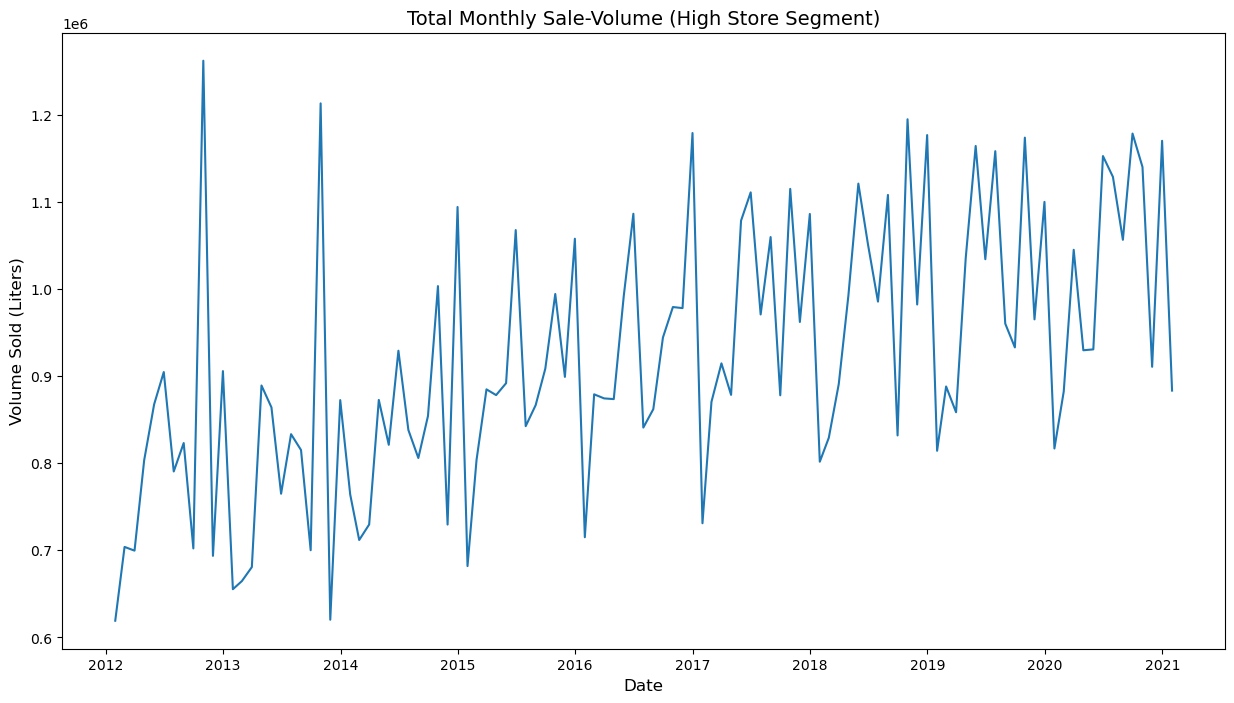

In [155]:
fig=sns.lineplot(AggrMonthlyHighStoresTrans.Date,AggrMonthlyHighStoresTrans['Volume Sold (Liters)'])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('Total Monthly Sale-Volume (High Store Segment)',fontsize=14)

In [156]:
TopHighStores=HighStoresTrans[['Store Number','Store Name','Volume Sold (Liters)']].groupby(['Store Number','Store Name']).sum()

In [157]:
TopHighStores.sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:20]

,,Volume Sold (Liters)
Store Number,Store Name,
2633,hy vee 3 bdi des moines,5173469.35
4829,central city 2,4244494.32
2512,hy vee wine and spirits iowa city,2443533.97
3385,sams club 8162 cedar rapids,2288896.45
3420,sams club 6344 windsor heights,2186949.55
3354,sams club 8238 davenport,1529290.15
3952,lot a spirits,1498502.21
3494,sams club 6514 waterloo,1308796.65
3773,benz distributing,1228897.30


This category contains wholesale stores like Sam's Club and Costco, besided Hy-Vee in the big cities of Iowa such as Des Moines, Iowa City, Cedar Rapids and Davenport.

In [45]:
TopItemsHighStores=HighStoresTrans[['Item Description','Volume Sold (Liters)']].groupby(['Item Description']).sum().sort_values(by=['Volume Sold (Liters)'],ascending=False)[0:10]

In [159]:
TopItemsHighStores

,Volume Sold (Liters)
Item Description,
black velvet,4113633.42
titos handmade vodka,2858754.56
hawkeye vodka,2844553.16
captain morgan spiced rum,2589134.34
barton vodka,2437730.89
fireball cinnamon whiskey,2223590.56
phillips vodka,1598420.48
jack daniels old 7 black lbl,1517133.85
five oclock vodka,1242963.24


In [46]:
TopTransHighStores=HighStoresTrans[HighStoresTrans['Item Description'].isin(TopItemsHighStores.index)]

In [49]:
TopTransHighStores['Date']= pd.to_datetime(TopTransHighStores['Date'])

<ipython-input-49-9f4311bf7da8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TopTransHighStores['Date']= pd.to_datetime(TopTransHighStores['Date'])


In [50]:
MonthlySalesHighStores=TopTransHighStores.groupby(['Item Description',pd.Grouper(key='Date', freq='M')]).sum().reset_index()
MonthlySalesHighStores.head()

,Item Description,Date,Sale (Dollars),Volume Sold (Liters),Store Number
0,barton vodka,2012-01-31,96404.56,16232.88,1247422
1,barton vodka,2012-02-29,107942.67,18188.50,1228366
2,barton vodka,2012-03-31,103335.04,17400.88,1288201
3,barton vodka,2012-04-30,118889.37,20031.62,1456653
4,barton vodka,2012-05-31,116010.38,19540.25,1525413


C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim

Text(0.5, 1.0, 'PLC of Top 10 Brands (High Store Segment)')

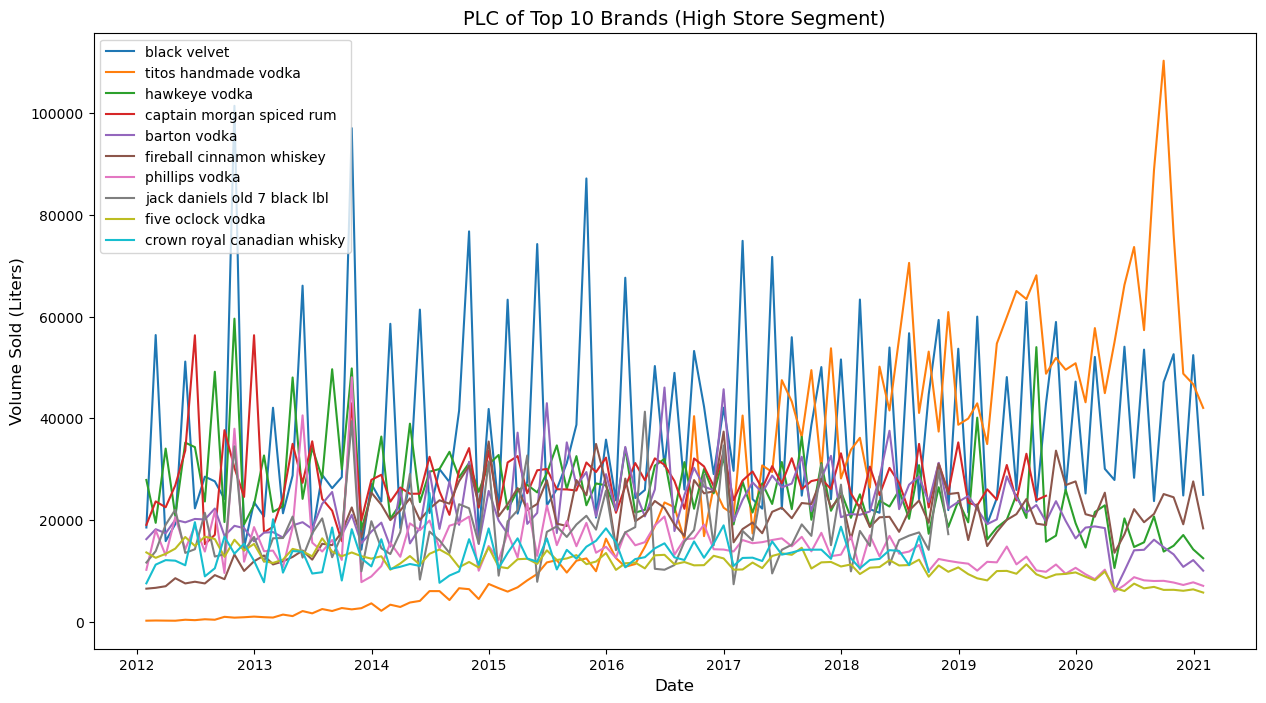

In [162]:
plt.rcParams['figure.figsize'] = (15,8)
for i in range(0,10,1):
    ItemVolSales=MonthlySalesHighStores[MonthlySalesHighStores['Item Description']==TopItemsHighStores.index[i]]
    #sns.lineplot(ItemVolSales.Date.dt.strftime('%Y-%m-%d'),ItemVolSales['Volume Sold (Liters)'],
     #            label=topbrands.index[i]).set_xticklabels(labels= ItemVolSales.Date.dt.strftime('%Y-%m-%d'),
      #                                                     rotation=90, ha='right')
    fig=sns.lineplot(ItemVolSales.Date,ItemVolSales['Volume Sold (Liters)'],label=TopItemsHighStores.index[i])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('PLC of Top 10 Brands (High Store Segment)',fontsize=14)

C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Ibrahim\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'PLC of Titos and Hawkeye (High Store Segment)')

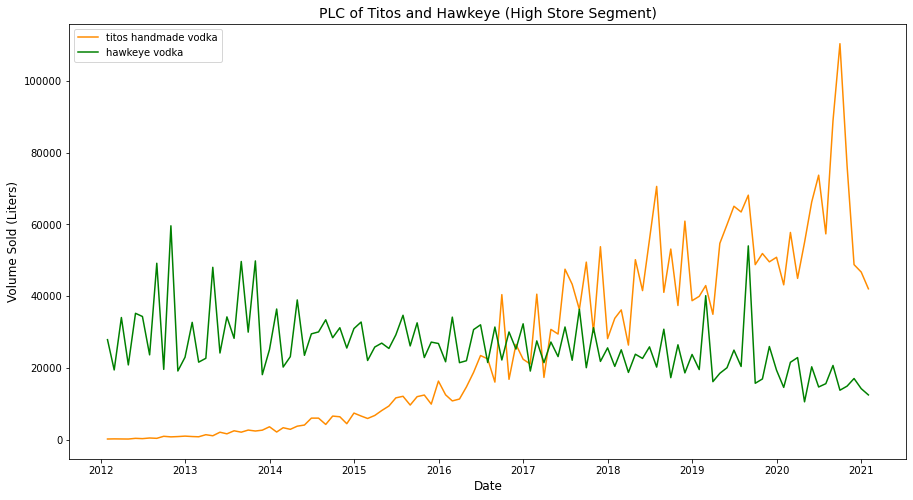

In [57]:
plt.rcParams['figure.figsize'] = (15,8)
colors=['','darkorange','green']
for i in range(1,3,1):
    ItemVolSales=MonthlySalesHighStores[MonthlySalesHighStores['Item Description']==TopItemsHighStores.index[i]]
    #sns.lineplot(ItemVolSales.Date.dt.strftime('%Y-%m-%d'),ItemVolSales['Volume Sold (Liters)'],
     #            label=topbrands.index[i]).set_xticklabels(labels= ItemVolSales.Date.dt.strftime('%Y-%m-%d'),
      #                                                     rotation=90, ha='right')
    fig=sns.lineplot(ItemVolSales.Date,ItemVolSales['Volume Sold (Liters)'],label=TopItemsHighStores.index[i],color=colors[i])
fig.set_xlabel('Date',fontsize=12)
fig.set_ylabel("Volume Sold (Liters)",fontsize=12)
fig.set_title('PLC of Titos and Hawkeye (High Store Segment)',fontsize=14)

The current marketing plan is working well. The same plans applied in the medium segment stores can be applied here to maintain and to increase the market share.

In [165]:
# Write a database for titos Trans to use for CLV prediction
db = sqlite3.connect("TitosTrans.sqlite")
TitosTrans.to_sql("TitosTrans",db,if_exists='replace', chunksize=1000,index=False)

C:\Users\Ibrahim\anaconda3\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(
